# Modeling age-related changes in electrical activity in CA1 pyramidal cells

### Erin C. McKiernan<sup>1</sup>, Marco A. Herrera-Valdez<sup>2</sup>, and Diano F. Marrone<sup>3</sup>

<sup>1</sup> Departamento de Física, Facultad de Ciencias, Universidad Nacional Autónoma de México <br/>
<sup>2</sup> Departamento de Matemáticas, Facultad de Ciencias, Universidad Nacional Autónoma de México <br/>
<sup>3</sup> Department of Psychology, Wilfrid Laurier University <br/>

## Overview

We are interested in modeling age-related changes in ion channel expression and electrical activity in CA1 pyramidal cells (PCs). However, before we can investigate aging, we have to create a representative model cell of a young CA1 PC. PCs in the CA1 region of the hippocampus show diverse firing patterns, including repetitive slow firing with frequency adaptation, conditional bursting (bursting in response only to a stimulus), and endogenous bursting in the absence of stimulation. We can build a 3-dimensional model, based on electrophysiological data, to determine under what conditions these different firing patterns can be reproduced. We will vary primarily the density of ion channels in the model membrane and specific biophysical properties of the channels, such as their rate of activation. In this way, we can understand the different balances of currents that produce these firing patterns, and then compare the firing in young and aged PCs under different conditions. We can assume that the passive membrane properties of young and aged CA1 PCs are the same but that the cells differ in their calcium channel density, as shown in the experimental literature, to explore one aspect of aging in these cells. For more information, see our article "A biophysical minimal model to investigate age-related changes in CA1 pyramidal cell excitability".    

## Setting up the notebook
First, we import the Python modules needed for computing and plotting figures. We include several commands to view plots in the Jupyter notebook, and to create figures with good resolution and large labels. These commands can be customized to produce figures with other specifications.

In [77]:
# import computing modules
import numpy as nu
import pyprocess as pyp # see Python documentation for install

# command to view figures in Jupyter notebook
%matplotlib inline 

# import plotting modules and settings
import matplotlib.pylab as pl 
import matplotlib.ticker as ticker # rescaling units in figures
from mpl_toolkits.axes_grid1.inset_locator import mark_inset # figure insets
from mpl_toolkits.axes_grid1.inset_locator import inset_axes # figure insets

# commands to create high-resolution figures with large labels
%config InlineBackend.figure_formats = {'png', 'retina'} 
pl.rcParams['axes.labelsize'] = 18 # fontsize for figure labels
pl.rcParams['axes.titlesize'] = 20 # fontsize for figure titles
pl.rcParams['font.size'] = 16 # fontsize for figure numbers
pl.rcParams['lines.linewidth'] = 1.6 # line width for plotting

## Defining auxiliary functions 
Next, we define the constants and auxiliary functions we need for the model. These include functions to construct the parameter dictionary, calculate the Boltzmann potential, and the sigmoidal function for the current activation curves.

In [78]:
# define constants
eCharge=1.60217733e-19 # Coulombs
kBoltzmann=1.38065812e-20 # mJ/K
zeroT=273.15 # degree Kelvin

# functions to build dictionary
def popDictKeys(di,keyList):
    ddi = di.copy()
    for kk in keyList:
        ddi.pop(kk)
    return ddi
    
def popDictKey(di,key):
    return {k:v for k,v in di.items() if k != key}

def gatherDicts(d, dList):
    for dl in dList:
        d.update(dl)
    return d

# calculate Boltzmann or thermal potential at specified temperature
def vBoltzmann(tempCelcius=37.0):
    return kBoltzmann*(zeroT+tempCelcius)/eCharge

# calculate sigmoids for the activation curves
def sigmoid(u,a):
    return u/(u + a)

# calculate slopes for voltsge derivative 
def calcSecants(x,y):
    dydx = nu.zeros(len(y))
    dydx[1:] = (y[1:]-y[:-1]) / (x[1:]-x[:-1])
    return dydx

# calcuate duration of action potentials (APs)
def calcPulseDuration(t,vAP,report=1):
    dvdt = calcSecants(t,vAP)
    a = dvdt.argmax()
    b = dvdt.argmin()
    if report==1:
        print('Pulse started at %g with max rate %g and ended at %g \
        with min rate %g'%(t[a],dvdt.max(),t[b],dvdt.min()))
    return t[b]-t[a]

# print Boltzmann/thermal potential 
print('v_T = %g'%vBoltzmann(37))

v_T = 26.7268


## Model for CA1 pyramidal cells

Now, we build a Python class that will be used to simulate the activity of CA1 PCs, given by the system of equations:

\begin{eqnarray}
C_m \partial_t v&=& I_{F} - I_{NaT}(v,w) - I_{CaL}(v,c) - I_{DK}(v,w) - I_{SK}(v,c) - I_{NaK}(v) \label{eq:dvdt}
\\
\partial_t w &=& w \left( S_w(v) - w\right) R_w(v)
\\
\partial_t c &=& r_c(c_{\infty}-c) - k_c I_{CaL}(v,c)
\end{eqnarray}

Different instances of the class can later be used to simulate different-aged PCs. The class includes a function which defines the right-hand side of the model. The model has three variables: the change in voltage (<i>v</i>), potassium channel activation (<i>w</i>), and intracellular calcium concentration (<i>c</i>). The currents include a transient sodium current (<i>NaT</i>), delayed rectifier potassium current (<i>DK</i>), L-type calcium current (<i>CaL</i>), calcium-dependent potassium current (<i>SK</i>), and a sodium-potassium pump (<i>NaK</i>). 

Note that all potentials in the model are normalized by $v_T$. Also, all potentials in the model are arguments inside exponential functions. Therefore, there are a few calculations that can be done before running a solver. The first two calculations that are repetitive are the normalization of potentials and the division of each of the currents by the membrane capacitance. For the normalization, we perform a change of variables $v \mapsto u = v/v_T$, which means that we can write a new equation from the fact that $\partial_t u = \partial_t v / v_T$. Having done the change of variables, we include the division by $C_m$ by rewriting the amplitudes for each of the currents as $a_x \mapsto A_x = a_x / v_T C_m$. The new currents are then mapped $I_x \mapsto J_x = I_x / (v_T C_m)$. The resulting system looks like 

\begin{equation}
\partial_t u= J_{F} - J_{NaT}(u,w) - J_{CaL}(u,c) - J_{DK}(u,w) - J_{SK}(u,c) - J_{NaK}(u). \label{eq:dudt}
\end{equation}



In [79]:
# class for CA1 pyramidal cells (PCs)
class pyrCA1:
    nDim = 3;
    def __init__(self,pars):
        self.dict2ClassPars(pars)    
        self.reparametrize() 
        return
    
    # for building parameter dictionary
    def dict2ClassPars(self,di):
        for k in di.keys():
            exec("self.%s = %g"%(k,di[k])); #print(str1)
        return
    
    # reparametrize model based on updated parameter values
    # normalize current amplitudes by Boltzmann potential * membrane capacitance
    def reparametrize(self):
        self.u_half_Act_DK = self.v_half_Act_DK/self.v_T
        self.u_half_Act_NaT = self.v_half_Act_NaT/self.v_T
        self.u_half_Act_CaL = self.v_half_Act_CaL/self.v_T
        self.u_ATP = self.v_ATP/self.v_T
        self.u_Na =  self.v_Na/self.v_T
        self.u_K =  self.v_K/self.v_T
        self.u_NaK =  self.u_ATP + 3*self.u_Na - 2*self.u_K 
        self.v_NaK =  self.u_NaK * self.v_T
        self.u0 = self.v0/self.v_T
        self.vTCm = self.v_T * self.C_m
        self.A_NaK = 2 * self.a_NaK / self.vTCm
        self.A_DK = 2 * self.a_DK / self.vTCm
        self.A_SK = 2 * self.a_SK / self.vTCm
        self.A_NaT = 2 * self.a_NaT / self.vTCm
        self.A_CaL = 4 * self.a_CaL / self.vTCm
        print('A_NaK = %g, A_DK = %g, A_SK = %g, A_NaT = %g, A_CaL = %g, \
        all in V/s'%(self.A_NaK, self.A_DK, self.A_SK, self.A_NaT, self.A_CaL))
        print('a_NaK = %g, a_DK = %g, a_SK = %g, a_NaT = %g, a_CaL = %g, \
        all in pA'%(self.a_NaK, self.a_DK, self.a_SK, self.a_NaT, self.a_CaL))
        return
    
    # print normalized current amplitudes
    def printNormAmps(self):
        print('A_NaK = %g, A_DK = %g, A_SK = %g, A_NaT = %g, A_CaL = %g, \
        all in V/s'%(self.A_NaK, self.A_DK, self.A_SK, self.A_NaT, self.A_CaL))
        print('a_NaK = %g, a_DK = %g, a_SK = %g, a_NaT = %g, a_CaL = %g, \
        all in pA'%(self.a_NaK, self.a_DK, self.a_SK, self.a_NaT, self.a_CaL))
        return 
    
    # forward rate of activation
    def alpha_w(self,u):
        gb = self.b_Act_DK * self.g_Act_DK
        return self.r_Act_DK * nu.exp(gb*(u-self.u_half_Act_DK))

    # backward rate of activation
    def beta_w(self,u):
        gb = (self.b_Act_DK-1) * self.g_Act_DK
        return self.r_Act_DK * nu.exp(gb*(u-self.u_half_Act_DK))

    # steady-state activation for delayed rectifier K+ channels
    def ss_Act_DK(self,u):
        return 1/(1 + nu.exp(self.g_Act_DK * (self.u_half_Act_DK - u) ))

    # steady-state activation for Na+ channels
    def ss_Act_NaT(self,u):
        return 1/(1 + nu.exp( self.g_Act_NaT * (self.u_half_Act_NaT - u) ))
    
    # steady-state activation for delayed rectifier Ca2+ channels
    def ss_Act_CaL(self,u):        
        return 1/(1 + nu.exp( self.g_Act_CaL * (self.u_half_Act_CaL - u) ))

    # steady-state activation for SK channels
    def ss_Act_SK(self,c):        
        return sigmoid( c**self.g_Act_SK, self.in_Ca_half_Act_SK**self.g_Act_SK)

    # flux calculations for different channels or pumps 
    def J_NaK(self,u): 
        return self.A_NaK * nu.sinh((u - self.u_NaK)/2 )

    def J_DK(self,x,u):        
        """The original amplitude is a_DK = A_DK * C_m * v_T"""
        return self.A_DK * x * nu.sinh((u - self.u_K)/2 )

    def J_SK(self,u,c): 
        """The original amplitude is a_SK = A_SK * C_m * v_T"""
        return self.A_SK * self.ss_Act_SK(c) * nu.sinh((u - self.u_K)/2 )

    def J_NaT(self,x,u):
        """The original amplitude is a_NaT = A_NaT * C_m * v_T"""
        return self.A_NaT * self.ss_Act_NaT(u) * (1-x) * nu.sinh((u - self.u_Na)/2 )

    def J_CaL(self,u,c):
        """The original amplitude is a_CaL = A_CaL * C_m * v_T/2"""
        return self.A_CaL * self.ss_Act_CaL(u) * nu.sinh( u - self.u_Ca )
    
    # define current clamp protocol used to stimulate PCs
    def IClamp(self):
        self.timeSamples = nu.arange(0,self.timeMax,self.timeStep)
        self.nSteps = len(self.timeSamples)
        self.iInds = nu.argwhere((self.timeSamples >= self.startIClamp) & \
                                 (self.timeSamples < self.stopIClamp))
        self.jClamp = nu.zeros(self.nSteps)
        self.jClamp[nu.squeeze(self.iInds)] = self.iClampAmp/self.vTCm
        print(nu.squeeze(self.iInds),self.jClamp)
        return self.jClamp
    
    # define OU forcing function
    def ouForcing(self):
        diffF=2*self.aSD/self.aTau
        aOU=pyp.OU_process(theta=1/self.aTau,mu=self.aMean,sigma=diffF)
        aOUPath= aOU.sample_path(self.timeSamples)[0] /self.vTCm
        return aOUPath

    def runWOU(self):
        self.timeSamples = nu.arange(0,self.timeMax,self.timeStep)
        ou1 = self.ouForcing()
        print(ou1)
        v,w,c = self.RK2_Autonomous(parNames=['A_F'],parValues=[ou1])
        return v,w,c
    
    # define dynamics of variables; note that u is normalized voltage
    def dynamics(self,Z):
        u,w,c = Z 
        self.u_Ca = nu.log(self.out_Ca/c) / self.val_Ca
        aw = self.alpha_w(u); bw = self.beta_w(u)
        JK = (self.A_DK * w + self.A_SK * self.ss_Act_SK(c)) * nu.sinh((u - self.u_K)/2)
        JCaL = self.J_CaL(u,c)
        dw = self.r_Act_DK * (w**self.expo_Act_DK) * (aw - (aw+bw)*w)
        du = self.A_F - self.J_NaK(u) - self.J_NaT(w,u) - JCaL - JK
        dc = self.r_in_Ca * (self.in_Ca_infty - c) - self.r_conv_Ca * JCaL
        #print('\n--------\n',u,w,c,'....',du,dw,dc)
        return nu.array([du,dw,dc])
    
    # time steps for customized solver below
    def RK2_Step(self, f, U):
        k = f(U) * self.timeStep / 2.0
        return U + self.timeStep * f(U + k)

    # define customized Runge-Kutta solver
    def RK2_Autonomous(self, parNames=[],parValues=[]):
        """Second-order Runge-Kutta method to solve x' = f(x) with U(t[0]) = U0.
        Numerical Analysis, 6th Edition, by Burden and Faires, Brooks-Cole, 1997.
        """
        print('Calculating numerical solution')
        nForc=len(parNames)
        print(parNames,parValues,'%d forcing parameters'%nForc)
        self.timeSamples = nu.arange(0,self.timeMax,self.timeStep)
        self.nSteps = len(self.timeSamples)
        print('nSteps = %d'%self.nSteps)
        U = nu.zeros((self.nSteps, self.nDim),"float64")
        U[0] = nu.array([self.v0/self.v_T,self.w0,self.c0])
        if nForc>0:
            for i in range(self.nSteps-1):
                for nn in range(nForc):
                    str1='self.%s = %g'%(parNames[nn],parValues[nn][i])
                    exec(str1);
                U[i+1] = self.RK2_Step(self.dynamics, U[i])
        else:
            for i in range(self.nSteps-1):
                U[i+1] = self.RK2_Step(self.dynamics, U[i])
        self.u, self.w, self.c = U.transpose()
        self.v = self.u * self.v_T
        return self.v,self.w,self.c
    
    # calculate various biophysical quantities, like non-normalized currents
    def calcBiophysicsFromDynamics(self,v,w,c):
        u = v/self.v_T
        self.dvdt = calcSecants(self.timeSamples,v)
        self.wInf = self.ss_Act_DK(u); 
        self.mInf = self.ss_Act_NaT(u); 
        self.ninf = self.ss_Act_CaL(u);
        self.walpha = self.alpha_w(u); 
        self.wbeta = self.beta_w(u); 
        self.wtau = 1/(alpha_w + beta_w)
        self.jNaK = self.J_NaK(u) * self.vTCm; 
        self.jDK = self.J_DK(w,u) * self.vTCm; 
        self.jNaT = self.J_NaT(w,u) * self.vTCm
        self.jCaL = self.J_CaL(u,c) * self.vTCm; 
        self.jSK = self.J_SK(u,c) * self.vTCm
        self.v_Ca = nu.log(self.out_Ca/c) * self.v_T / self.val_Ca 
        return self.v,self.w,self.c
    
    # calcuate duration of action potentials (APs)
    def calcAPDuration(self,ta,tb):
        a = nu.int32(ta/self.timeStep)
        b = nu.int32(tb/self.timeStep)
        calcPulseDuration(self.timeSamples[a:b],self.v)
        return

    # define function for plotting steady states, currents, etc.
    # can use this out of the box, or build customized figures
    def plotSteadyStates(self):
        vSS = nu.linspace(-100,100.0,400); 
        uSS = vSS / self.v_T
        wInf = self.ss_Act_DK(uSS); 
        mInf = self.ss_Act_NaT(uSS); 
        ninf = self.ss_Act_CaL(uSS)
        alphaw = self.alpha_w(uSS); 
        betaw = self.beta_w(uSS); 
        tauw = 1/(alphaw + betaw)
        tcw = (alphaw**self.expo_Act_DK) / (alphaw + betaw)**(self.expo_Act_DK -1) 
        INaK = self.J_NaK(uSS) * self.vTCm; 
        IDK = self.J_DK(wInf,uSS) * self.vTCm; 
        INaT = self.J_NaT(wInf,uSS) * self.vTCm
        ICaL = self.J_CaL(uSS,0.00001)* self.vTCm; 
        ISK = self.J_SK(uSS,0.00001)* self.vTCm
        #
        fig = pl.figure(figsize=(15,15)); rows=3; cols=1
        ax_w1 = fig.add_subplot(rows,cols,1); ax_w2 = ax_w1.twinx()
        ax_ss_Act = fig.add_subplot(rows,cols,2);
        ax_ssI1 = fig.add_subplot(rows,cols,3);  ax_ssI2 = ax_ssI1.twinx() 
        ax_w2.plot(vSS, alphaw, label=r'$\alpha_w(v)$'); 
        ax_w2.plot(vSS, betaw,label=r'$\beta_w(v)$'); 
        ax_w2.legend(loc='upper right'); 
        ax_w2.set_ylabel('1/ms',labelpad=30,rotation=-90) 
        ax_w2.set_ylim(-0.1,5);
        ax_w1.plot(vSS, tauw, 'k', label=r'$\tau_w$');
        ax_w1.legend(loc='upper left'); ax_w1.set_ylabel('ms',labelpad=20) 
        ax_w1.set_ylim(0,1.1*tauw.max());
        ax_ss_Act.plot(vSS, wInf, label=r'$w_{\infty}(v)$')
        ax_ss_Act.plot(vSS, mInf, label=r'$m_{\infty}(v)$')
        ax_ss_Act.plot(vSS, ninf, 'k', label=r'$n_{\infty}(v)$')
        ax_ss_Act.legend(loc='upper left'); 
        #
        ax_ssI1.plot([vSS.min(),vSS.max()],[0,0], 'k:')
        ax_ssI2.plot([vSS.min(),vSS.max()],[0,0], 'k:')
        ax_ssI2.plot(vSS,INaK, 'k', label=r'$a_{NaK} \varphi_{NaK}(v)$')
        ax_ssI1.plot(vSS,IDK, label=r'$a_{DK} w_{\infty}(v) \varphi_{DK}(v)$')
        ax_ssI1.plot(vSS,INaT, label=r'$a_{NaT} m_{\infty}(v) (1-w_{\infty}(v)) \varphi_{NaT}(v)$')
        ax_ssI1.plot(vSS,ICaL, label=r'$a_{CaL} n_{\infty}(v)  \varphi_{CaL}(v)$')
        ax_ssI1.plot(vSS,ISK, label=r'$a_{SK} H_{SK}(c) \varphi_{SK}(v)$')
        ax_ssI1.legend(loc='upper left'); ax_ssI1.set_ylim(-6000,6000); 
        ax_ssI1.set_xlabel('mV',labelpad=20);
        ax_ssI1.set_ylabel('pA');
        ax_ssI2.legend(loc='lower right'); ax_ssI2.set_ylabel('pA',labelpad=30, rotation=-90)
        ax_ssI2.set_xlabel('V(mV)');
        return 
    
    # define function for plotting voltage, calcium dyanmics, currents, etc.
    # can use this out of the box, or build customized figures
    def plotDynamicalProfile(self):
        figD = pl.figure(figsize=(15,15)); pl.ioff(); 
        rows=1; cols=2; maxLargeCurrent = 7000
        axBottom = 0.1; axTop = 1-axBottom
        axLeft= 0.075; lColW=0.7; rColW=0.25; rowHeight=0.3
        ax_v = figD.add_axes([axLeft,axTop,lColW,rowHeight]); 
        ax_vCa = ax_v.twinx()
        ax_dv = figD.add_axes([2*axLeft + lColW, axTop,rColW,rowHeight]); 
        ax_I = figD.add_axes([axLeft, axTop-rowHeight-0.1,lColW,rowHeight]); 
        ax_Jdv = figD.add_axes([2*axLeft + lColW, axTop-rowHeight-0.1,rColW,rowHeight]);
        ax_c_SK =  figD.add_axes([axLeft, axBottom,lColW,rowHeight]); 
        ax_c = ax_c_SK.twinx()
        ax_cdv = figD.add_axes([2*axLeft + lColW, axBottom,rColW,rowHeight]);
        #
        ax_v.plot(self.timeSamples, v, 'k',ms=1, label=r'$v(t)$'); 
        ax_vCa.plot(self.timeSamples, self.v_Ca, 'b',ms=2, label=r'$v_{Ca}$'); 
        ax_dv.plot(self.dvdt,v,'k.', ms=1, label=r'$\partial_t v$'); 
        ax_I.plot(self.timeSamples, self.jNaT, 'g', ms=3, alpha = 0.65, label=r'$I_{NaT}(v,w)$'); 
        ax_I.plot(self.timeSamples, self.jDK, 'r', ms=1, alpha = 0.65, label=r'$I_{DK}(v,w)$'); 
        ax_I.plot(self.timeSamples, self.jCaL, 'b',ms=3, alpha = 0.65, label=r'$I_{CaL}(v,c)$'); 
        ax_I.plot(self.timeSamples, self.jSK, 'm.',ms=1, alpha = 0.75, label=r'$I_{SK}(v,c)$'); 
        ax_Jdv.plot(self.dvdt, self.jNaT, 'g.',ms=1, alpha = 0.65, label=r'$(\partial_t v, I_{NaT})$'); 
        ax_Jdv.plot(self.dvdt, self.jDK, 'r.',ms=1, alpha = 0.65, label=r'$(\partial_t v, I_{DK})$'); 
        ax_Jdv.plot(self.dvdt, self.jCaL, 'b',ms=1, alpha = 0.65, label=r'$(\partial_t v, I_{CaL})$'); 
        ax_Jdv.plot(self.dvdt, self.jSK, 'm.',ms=1, alpha = 0.65, label=r'$(\partial_t v, I_{SK})$'); 
        ax_c.plot(self.timeSamples, c*1000, 'b',ms=2, label=r'$c(t)$'); 
        ax_c_SK.plot(self.timeSamples, self.ss_Act_SK(c), 'm',ms=2, label=r'$p_{SK}$'); 
        ax_cdv.plot(self.jCaL, c*1000, 'b.',ms=2, label=r'$(I_{CaL}, c)$'); 
        #
        ax_vCa.legend(loc='lower left'); ax_dv.set_xlabel(r'$\partial_t v$')
        ax_v.legend(loc='upper left'); ax_v.set_ylabel('mV') 
        ax_I.legend(loc='upper left'); ax_I.set_ylabel('pA');
        ax_I.set_ylim(-maxLargeCurrent,maxLargeCurrent) 
        ax_Jdv.legend(loc='upper left'); ax_Jdv.set_ylabel('pA'); 
        ax_Jdv.set_xlabel(r'$\partial_t v$')
        ax_Jdv.set_ylim(-maxLargeCurrent,maxLargeCurrent) 
        ax_c.set_ylabel('uM',labelpad=10,rotation=0); 
        ax_c_SK.set_ylim(0,1) 
        ax_c_SK.set_ylabel('$P_{open}(K_S)$',labelpad=10,rotation=90);  
        ax_c_SK.legend(loc='upper center'); 
        ax_c.legend(loc='upper right'); 
        ax_c.set_ylim(0,0.5); 
        ax_cdv.set_ylim(0,0.5); 
        ax_cdv.set_xlabel(r'$I_{CaL}$ (pA)')
        pl.ion(); pl.draw()
        #start = nu.int32(200/self.timeStep); stop =nu.int32(220/self.timeStep)
        #APDuration = calcPulseDuration(self.timeSamples[start:stop],v[start:stop])
        #print('AP duration = %g ms'%APDuration)def J_NaT(self,x,y)
        return 
    

## Building the parameter dictionary
Next, we build our parameter dictionary. We do this in parts, i.e. all the ion concentrations, valences, and other biophysical parameters like temperature are grouped together (ionBP), then all the current amplitudes (amps), etc. We then gather all these smaller dictionaries together in a larger main dictionary. Some of these parameter values will then stay fixed for all simulations, while others will be varied to generate different firing patterns or simulate aging. 

In [80]:
# ion concentrations, valences, and biophysical params like temp, membrane capacitance, etc.
# all units for concentration in mM; note 1uM would be 1e-3 and 1nM would be 1e-6
ionBP={'out_Ca': 1.5, 
       'in_Ca': 1e-4, 
       'in_Ca_half_Act_SK':7.4e-4,
       'in_Ca_infty':1e-4,
       'val_Ca':2,
       'val_Na':1,
       'val_K':1,
       'tempCelcius':37.0,
       'C_m':25.0}
# current amplitudes; all units in pA
amps = {'a_NaT':1000.0,
        'a_NaK': 1000/100.0,
        'a_DK': 8000, 
        'a_CaL': 25.0, #50, if aged PC
        'a_SK': 1400.0, 
        'a_F': 0.0,
        'iClampAmp':100.0}
# activation slope factors, aka gating charges  
gains = {'g_Act_NaT':5.0, 
         'g_Act_DK':3.8,
         'g_Act_CaL':5.0,
         'g_Act_SK':2.0, 
         'expo_Act_DK':1}
biases = {'b_Act_DK':0.3} 
# rate of Ca2+ removal, K+ channel activation, Ca2+ conversion factor
rates = {'r_in_Ca': 1e-3,
         'r_Act_DK': 1.0,
         'r_conv_Ca': 3e-6}
# half-activation voltages, and Boltzmann calculation
volts = {'v_half_Act_DK': -1.0, 
         'v_half_Act_NaT': -19.0, 
         'v_half_Act_CaL': 3.0, 
         'v_ATP':-420.0, 
         'v_Na': 60.0, 'v_K':-89, 
         'v_T': vBoltzmann(ionBP['tempCelcius'])} 
# time steps, max time, and start and stop times for IClamp
times = {'timeStep':1.0/40.0, 
         'timeMax':1200,
         'iCStart':200.0, 
         'iCStop':1000.0}
# settings for OU forcing
ous = {'aMean':35.0,
       'aSD':20.0,
       'aTau':1/2.0}
# initial conditions for voltage, K+ channel activation, Ca2+ concentration 
ics = {'v0':-70.0,
       'w0':0.001,
       'c0':1e-4}

# gather all dictionaries together (can replace different dictionaries for different configurations)
pars = gatherDicts(dict(),[ionBP,amps,gains,biases,rates,volts,times,ous,ics])

Now we can create an instance of the class, feeding in the parameter dictionary, and print values to check it's working correctly. 

In [81]:
# create an instance of the class
nrn = pyrCA1(pars)
#
print('v_T = %g mV, v_ATP = %g mV' % (nrn.v_T, nrn.v_ATP))
print('v_Na = %g mV, v_K = %g mV, v_NaK= %g mV' % (nrn.v_Na, nrn.v_K, nrn.v_NaK))

A_NaK = 0.0299325, A_DK = 23.946, A_SK = 4.19055, A_NaT = 2.99325, A_CaL = 0.149663,         all in V/s
a_NaK = 10, a_DK = 8000, a_SK = 1400, a_NaT = 1000, a_CaL = 25,         all in pA
v_T = 26.7268 mV, v_ATP = -420 mV
v_Na = 60 mV, v_K = -89 mV, v_NaK= -62 mV


We can also check that the current clamp protocol for stimulation is working.

In [82]:
# checking I-Clamp protocol
nrn.startIClamp = 100; nrn.stopIClamp = 150; nrn.iClampAmp=50; nrn.timeMax=400; 
iClamp = nrn.IClamp()

[4000 4001 4002 ... 5997 5998 5999] [0. 0. 0. ... 0. 0. 0.]


Finally, we can calculate and plot the steady-state activation curves, currents, etc.

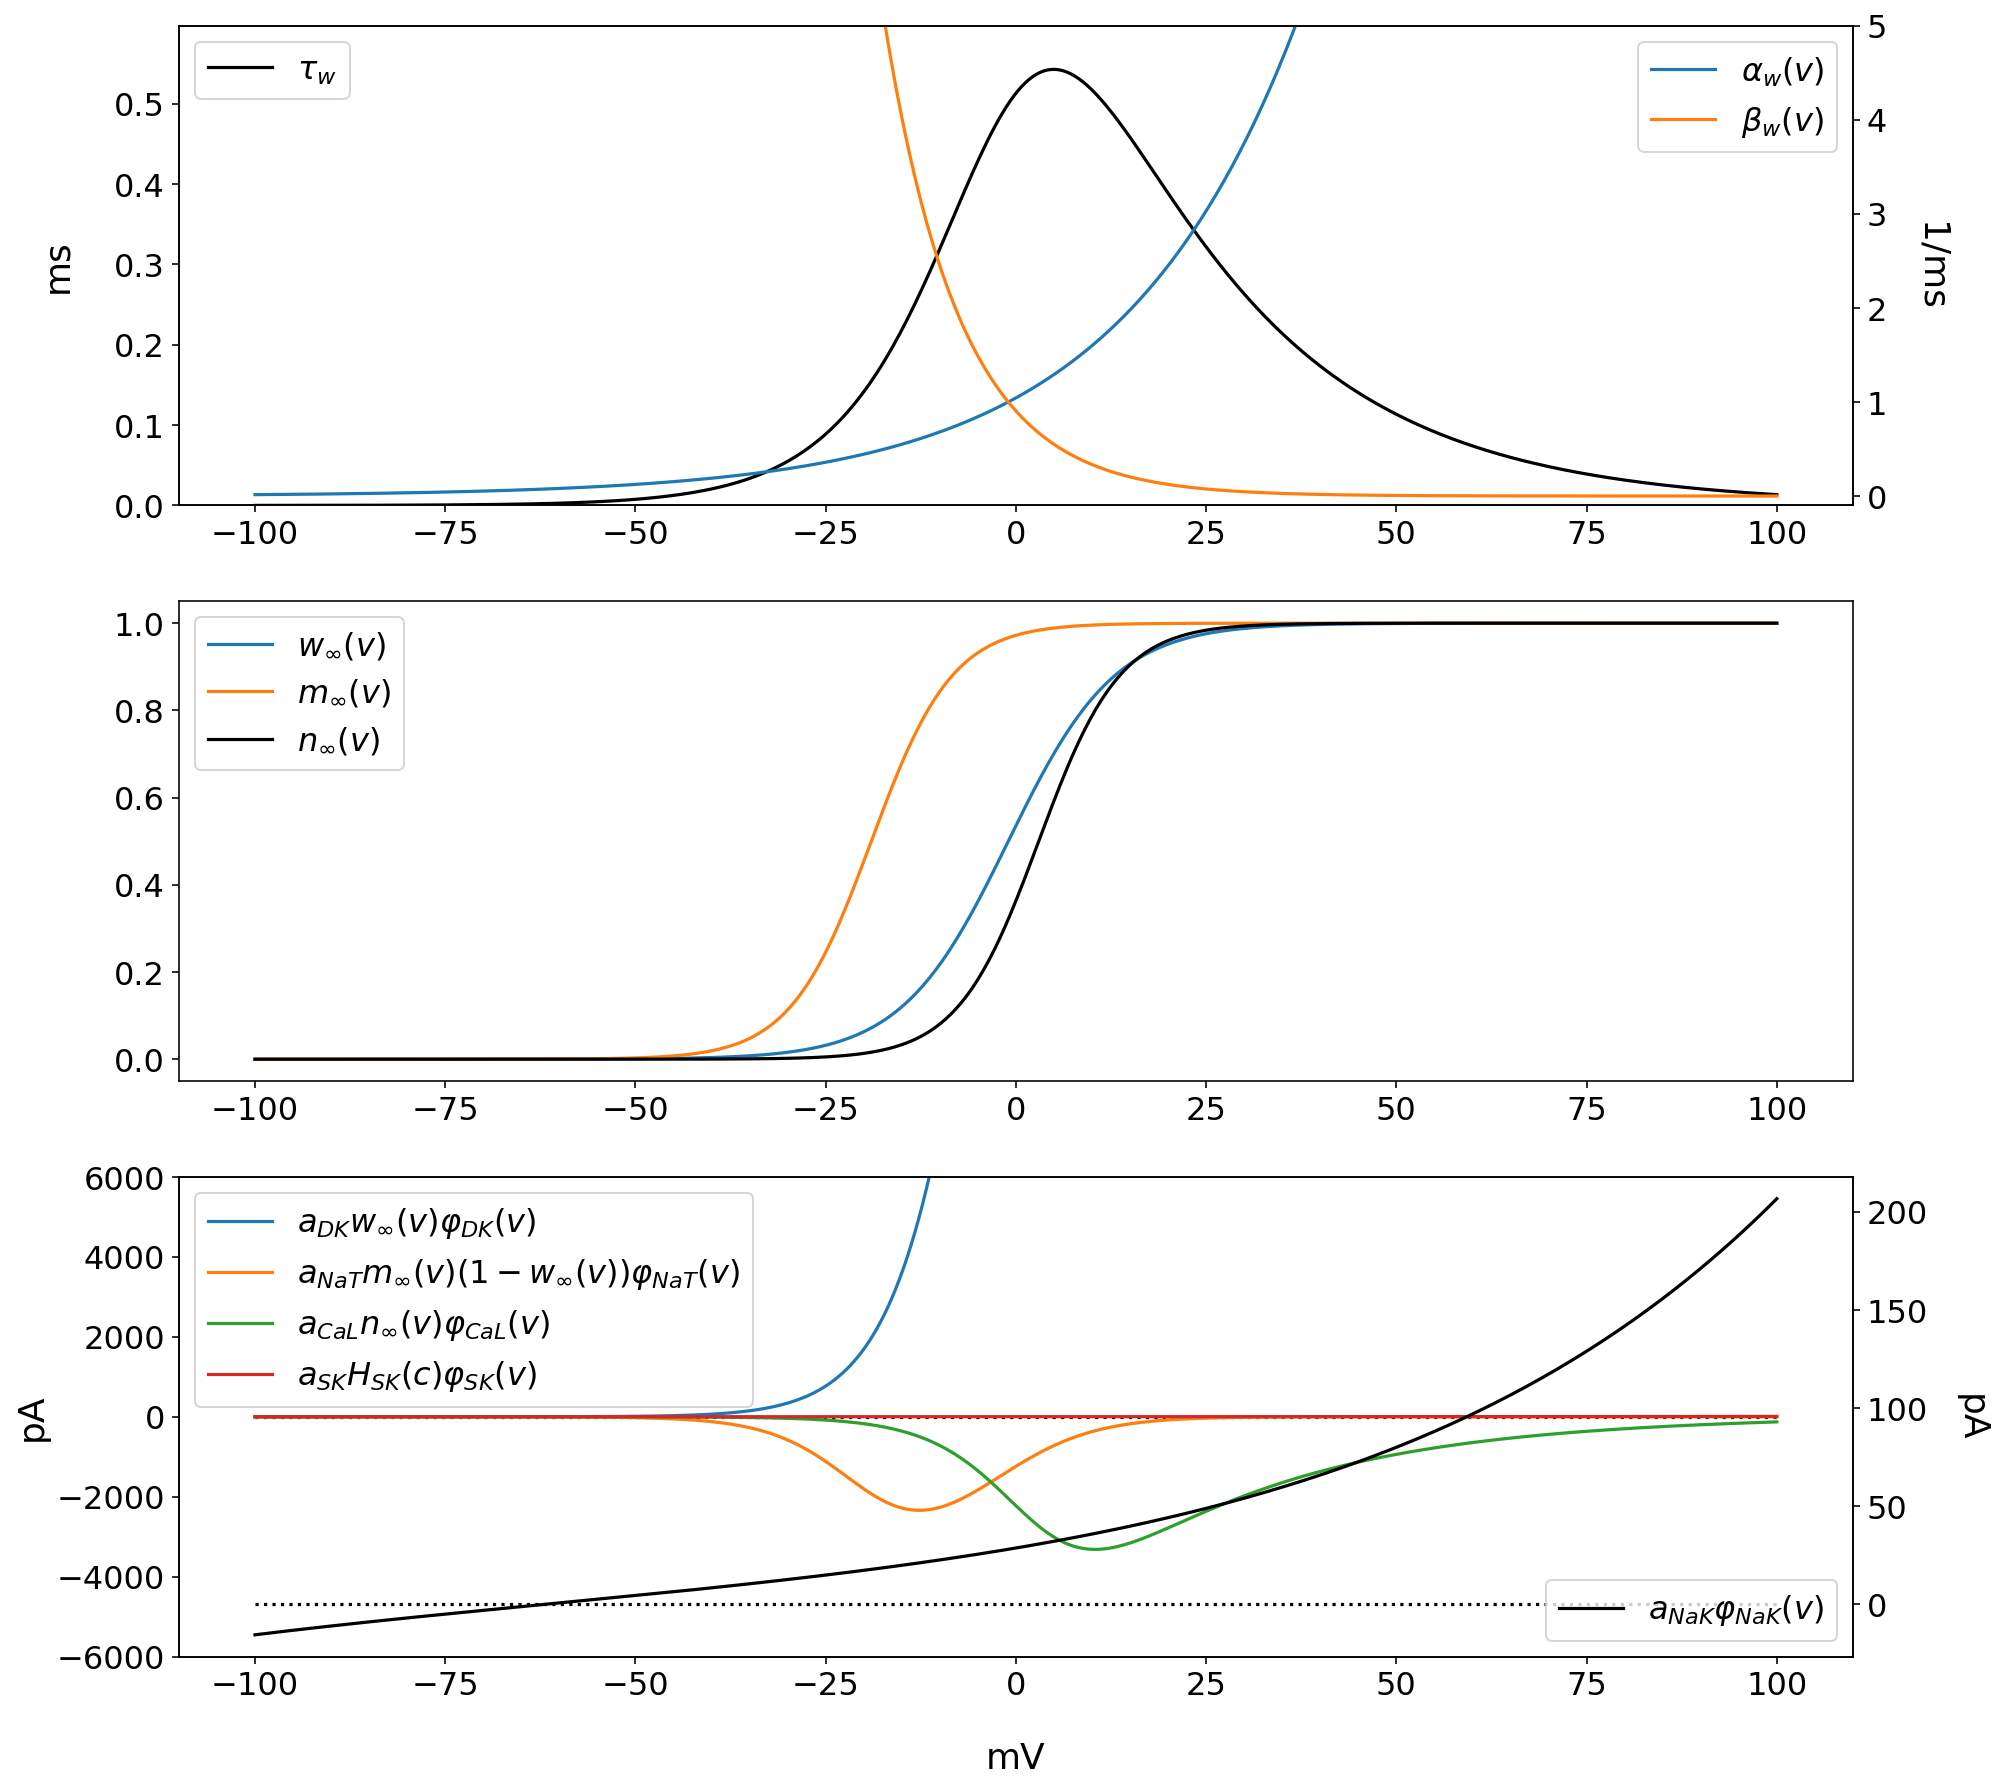

In [83]:
vSS = nu.linspace(-100,100.0,400); 
ySS = nu.exp(vSS / nrn.v_T)
wInf = nrn.ss_Act_DK(ySS); mInf = nrn.ss_Act_NaT(ySS); ninf = nrn.ss_Act_CaL(ySS)
alpha_w = nrn.alpha_w(ySS); beta_w = nrn.beta_w(ySS); tau_w = 1/(alpha_w + beta_w)
INaT = nrn.J_NaT(wInf,ySS) * nrn.vTCm
IDK = nrn.J_DK(wInf,ySS) * nrn.vTCm 
ISK = nrn.J_SK(ySS,0.00001)* nrn.vTCm
INaK = nrn.J_NaK(ySS) * nrn.vTCm
nrn.u_Ca = nu.log(nrn.out_Ca/nrn.in_Ca) / nrn.val_Ca
ICaL = nrn.J_CaL(ySS,0.00001)* nrn.vTCm 
#
nrn.plotSteadyStates();

Once we have everything set up, then we can move on to generating different firing patterns corresponding to PC activity.

## Simulating CA1 PC electrical activity

### Repetitive slow firing with spike frequency adaptation

Many CA1 pyramidal cells respond to square-pulse current injection by firing several early spikes followed by marked adaptation, which slows the frequency of firing. In aged animals, this adaptation is more pronounced than in young animals, leading to a shorter initial period of fast spiking, followed by fewer spikes or even complete cessation of activity. The increased adaptation seen in aged PCs is functionally relevant, as it is correlated with learning impairment. (See our main article for more information and citations.) Thus, our first challenge was to tune the model to produce early-onset firing with spike frequency adaptation. The baseline parameter regime specified above produces this firing pattern (see article for more details). The following commands run the model:

In [84]:
# running with above parameters and class instance
nrn.reparametrize()
nrn.v0 = -70.0; nrn.w0 = 0.001; nrn.c0=1e-4;
nrn.timeMax = 1200.0;  nrn.timeStep = 1.0/40.0; 
nrn.startIClamp = 200; nrn.stopIClamp = 1000; 
nrn.iClampAmp=1*100.0; # divide iClampAmp by vTCm for final stimulation amplitude (in nA)
iClamp = nrn.IClamp(); 
v,w,c = nrn.RK2_Autonomous(parNames=['A_F',],parValues=[iClamp,])
nrn.calcBiophysicsFromDynamics(v,w,c);

A_NaK = 0.0299325, A_DK = 23.946, A_SK = 4.19055, A_NaT = 2.99325, A_CaL = 0.149663,         all in V/s
a_NaK = 10, a_DK = 8000, a_SK = 1400, a_NaT = 1000, a_CaL = 25,         all in pA
[ 8000  8001  8002 ... 39997 39998 39999] [0. 0. 0. ... 0. 0. 0.]
Calculating numerical solution
['A_F'] [array([0., 0., 0., ..., 0., 0., 0.])] 1 forcing parameters
nSteps = 48000


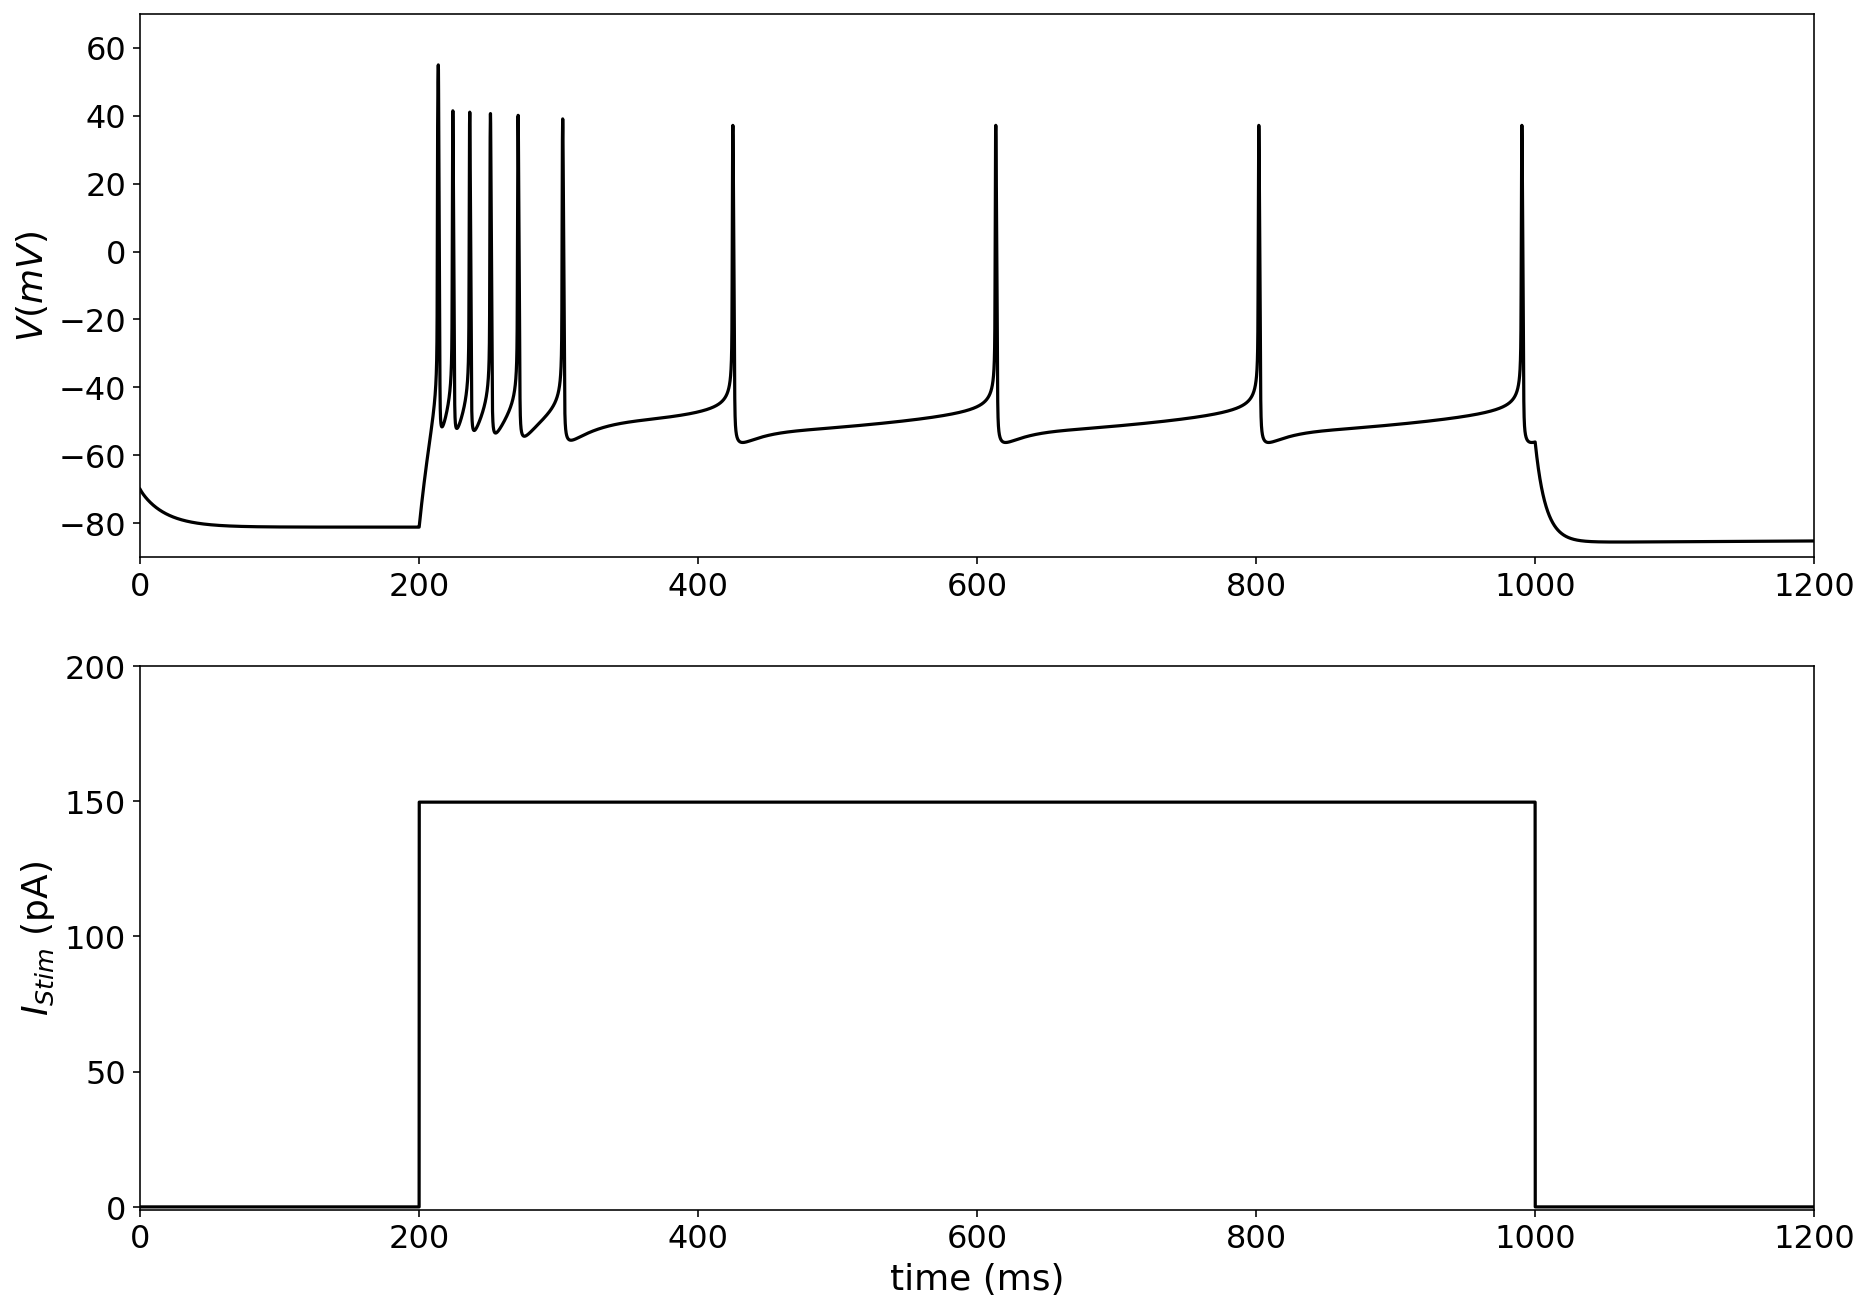

In [85]:
# plot results 
ax1=list()
fig1=pl.figure(figsize=(15,11))
pl.ioff()
rows=2; cols=1
for s in nu.arange(rows*cols):
    ax1.append(fig1.add_subplot(rows,cols,s+1))

ax1[0].plot(nrn.timeSamples, v, 'k', ms=1)
ax1[0].set_xlim(0,1200)
ax1[0].set_ylim(-90,70)
ax1[0].set_ylabel(r'$V(mV)$')
ax1[1].plot(nrn.timeSamples,iClamp*1000,'k')
ax1[1].set_xlim(0,1200)
ax1[1].set_ylim(-1,200)
ax1[1].set_ylabel('$I_{Stim}$ (pA)')
ax1[1].set_xlabel('time (ms)');

If we plot the spiking response above on a smaller time scale and also plot each current, we can see that the model produces ion currents within the same magnitude range as those seen in CA1 PC recordings (see paper for details and references).

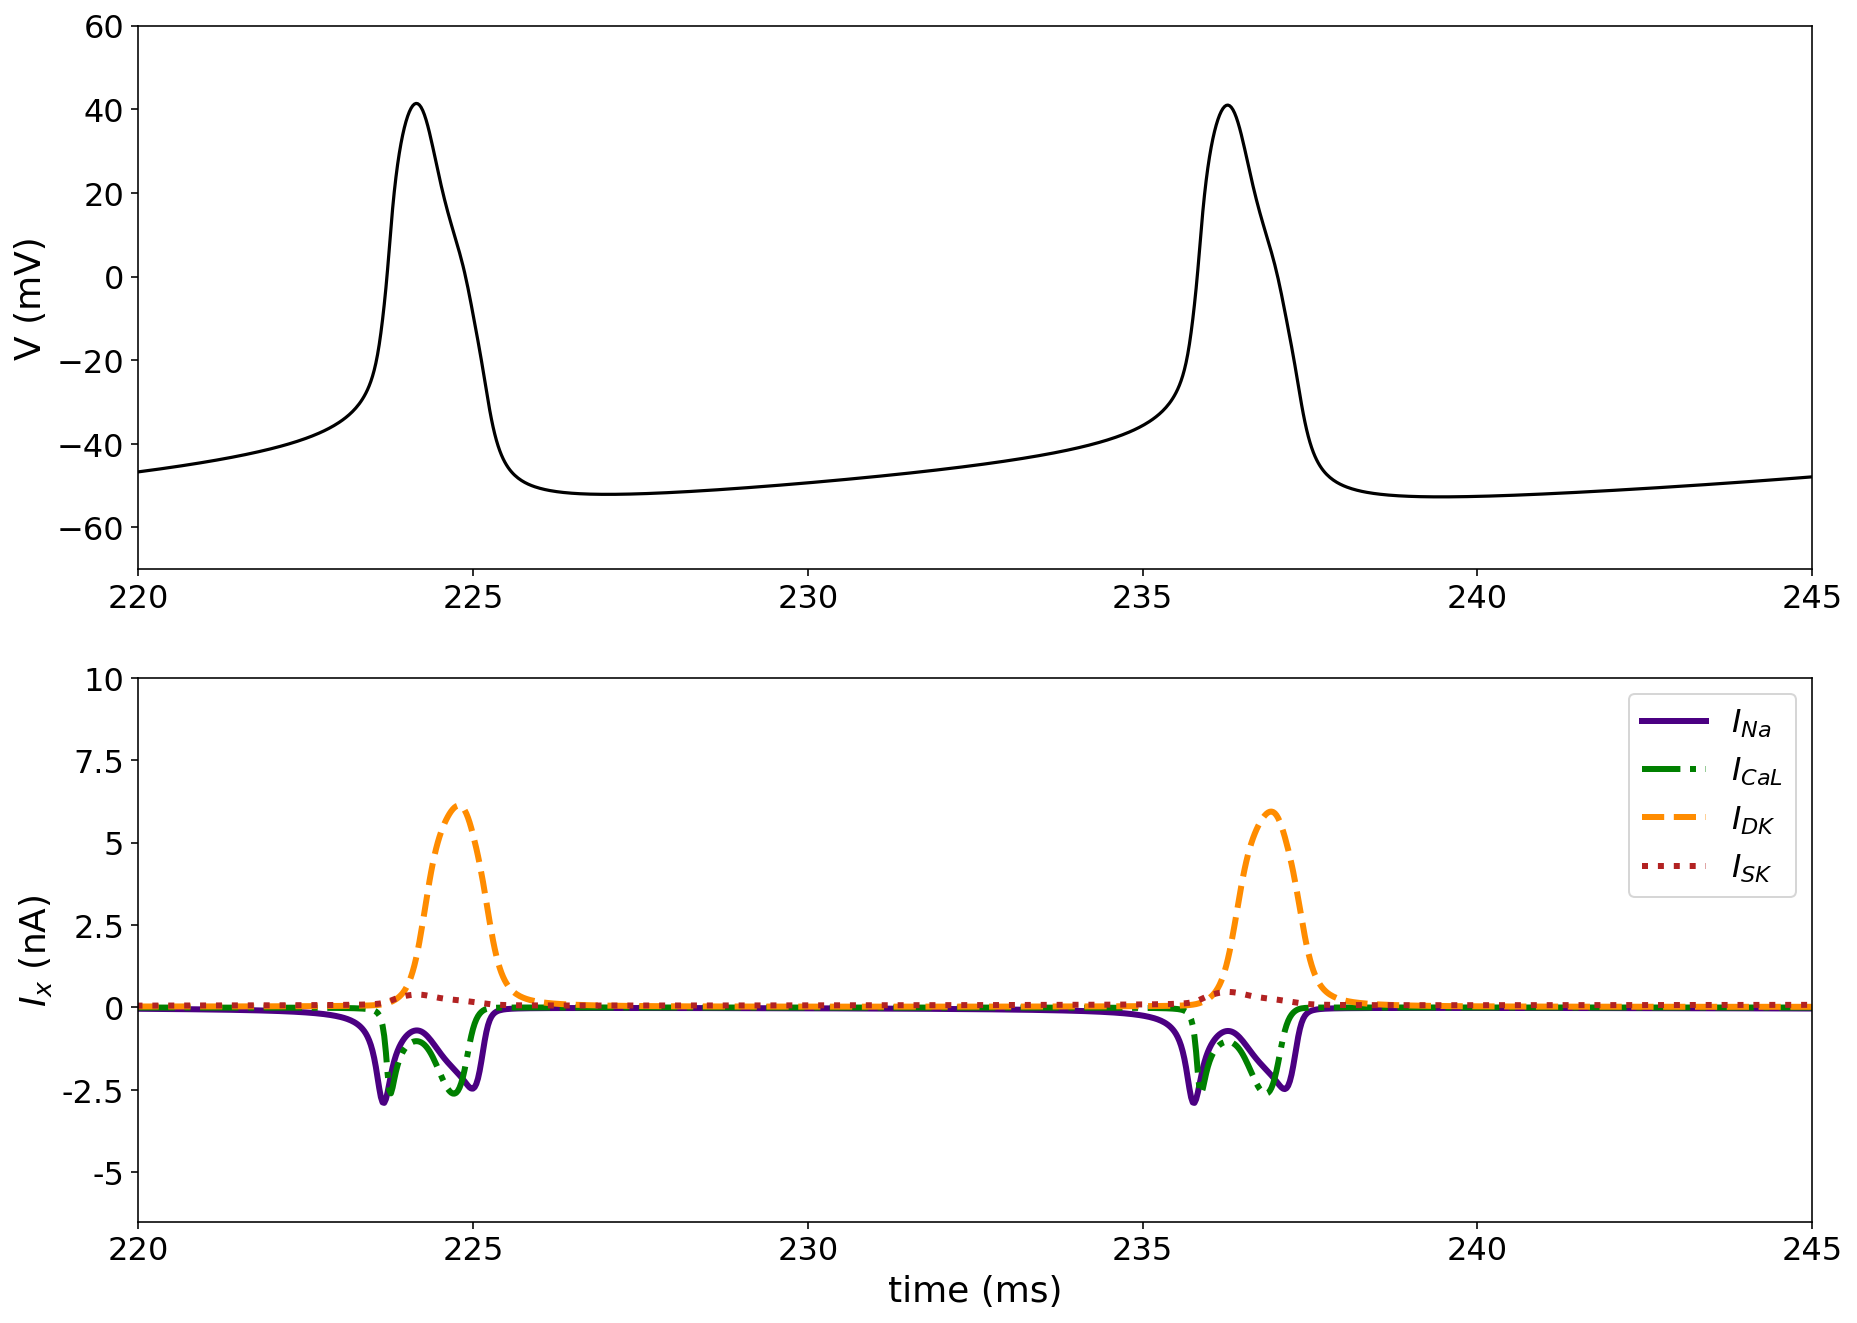

In [86]:
# plot just two spikes from above simulation and currents
ax1=list()
fig1=pl.figure(figsize=(15,11))
pl.ioff()
rows=2; cols=1
for s in nu.arange(rows*cols):
    ax1.append(fig1.add_subplot(rows,cols,s+1))

ax1[0].plot(nrn.timeSamples, v,'k')
ax1[0].set_xlim(220,245)
ax1[0].set_ylim(-70,60)
ax1[0].set_ylabel('V (mV)')

ticks_y=ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1000))
ax1[1].yaxis.set_major_formatter(ticks_y)
ax1[1].plot(nrn.timeSamples, nrn.jNaT, linestyle='solid', linewidth=3.0, color="indigo", label=r'$I_{Na}$')
ax1[1].plot(nrn.timeSamples, nrn.jCaL, linestyle='dashdot', linewidth=3.0, color="green", label=r'$I_{CaL}$')
ax1[1].plot(nrn.timeSamples, nrn.jDK, linestyle='dashed', linewidth=3.0, color="darkorange", label=r'$I_{DK}$')
ax1[1].plot(nrn.timeSamples, nrn.jSK, linestyle='dotted', linewidth=3.0, color="firebrick", label=r'$I_{SK}$')
#ax1[1].plot(nrn.timeSamples, nrn.jNaK, label=r'$I_{NaK}$') 
ax1[1].set_xlabel('time (ms)')
ax1[1].set_ylabel('$I_{x}$ (nA)')
ax1[1].set_xlim(220,245)
ax1[1].set_ylim(-6500,10000)
ax1[1].legend(loc="upper right");

We can now run the model for different sets of parameters to explore the effects on CA1 PC firing. To compare young and aged model PCs, we generate two instances of the class. The instances have all the same base set of parameters from the original instance except for the amplitude of the L-type Ca<sup>2+</sup> current, which was set to produce currents of around 2-3 nA or 5-6 nA - roughly the same magnitudes as those seen in recordings from young and aged PCs, respectively (see main article for details). 

In [87]:
# young PC
nrn_y = pyrCA1(pars)
nrn_y.a_CaL = 25.0;
nrn_y.reparametrize()
v,w,c = nrn_y.RK2_Autonomous(parNames=['A_F',],parValues=[iClamp,])
nrn_y.calcBiophysicsFromDynamics(v,w,c);

# aged (old) PC
nrn_o = pyrCA1(pars)
nrn_o.a_CaL = 50.0;
nrn_o.reparametrize()
v,w,c = nrn_o.RK2_Autonomous(parNames=['A_F',],parValues=[iClamp,])
nrn_o.calcBiophysicsFromDynamics(v,w,c);

A_NaK = 0.0299325, A_DK = 23.946, A_SK = 4.19055, A_NaT = 2.99325, A_CaL = 0.149663,         all in V/s
a_NaK = 10, a_DK = 8000, a_SK = 1400, a_NaT = 1000, a_CaL = 25,         all in pA
A_NaK = 0.0299325, A_DK = 23.946, A_SK = 4.19055, A_NaT = 2.99325, A_CaL = 0.149663,         all in V/s
a_NaK = 10, a_DK = 8000, a_SK = 1400, a_NaT = 1000, a_CaL = 25,         all in pA
Calculating numerical solution
['A_F'] [array([0., 0., 0., ..., 0., 0., 0.])] 1 forcing parameters
nSteps = 48000
A_NaK = 0.0299325, A_DK = 23.946, A_SK = 4.19055, A_NaT = 2.99325, A_CaL = 0.149663,         all in V/s
a_NaK = 10, a_DK = 8000, a_SK = 1400, a_NaT = 1000, a_CaL = 25,         all in pA
A_NaK = 0.0299325, A_DK = 23.946, A_SK = 4.19055, A_NaT = 2.99325, A_CaL = 0.299325,         all in V/s
a_NaK = 10, a_DK = 8000, a_SK = 1400, a_NaT = 1000, a_CaL = 50,         all in pA
Calculating numerical solution
['A_F'] [array([0., 0., 0., ..., 0., 0., 0.])] 1 forcing parameters
nSteps = 48000


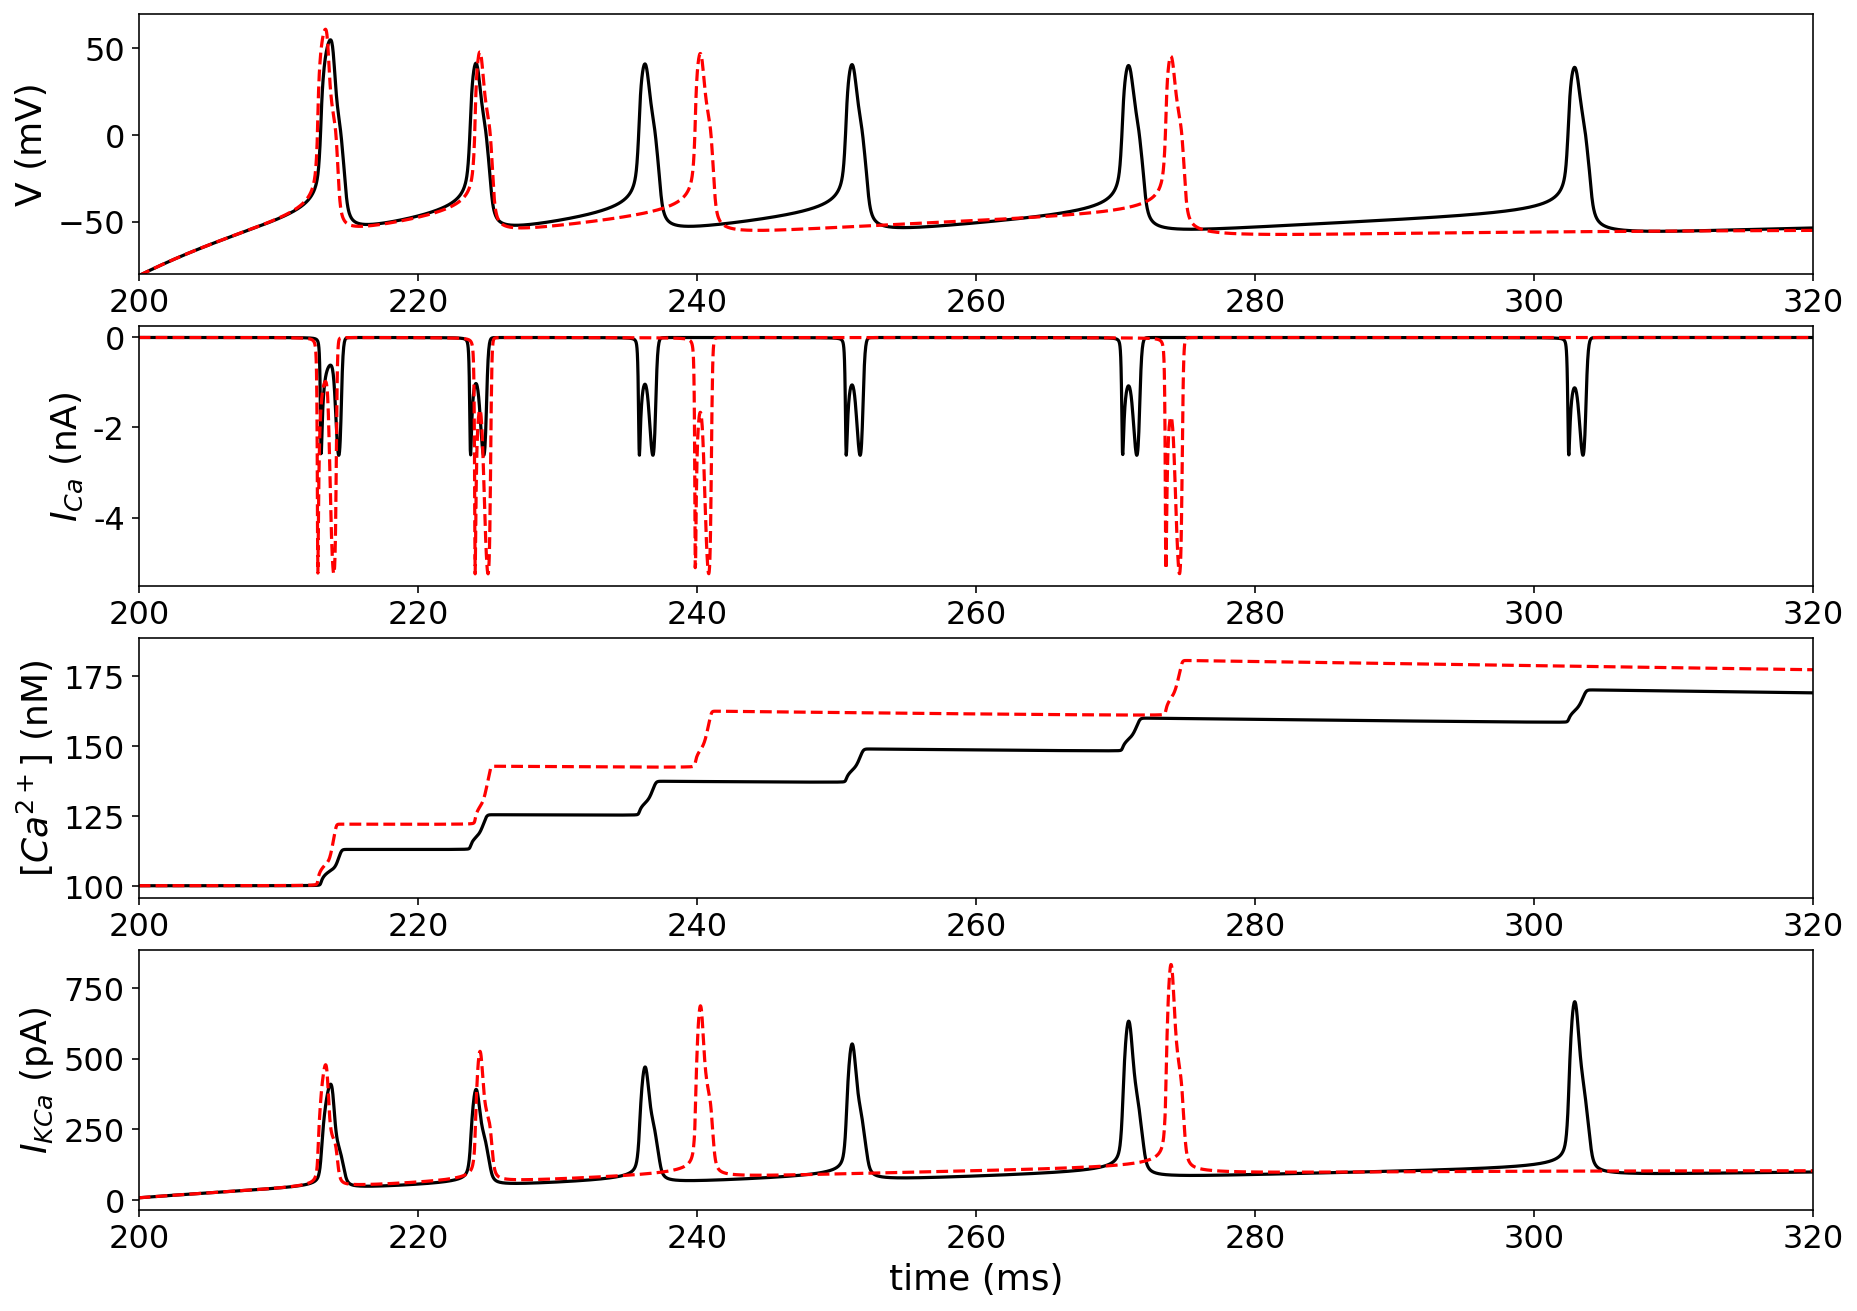

In [88]:
# plot results of previous simulations
ax1=list()
fig1=pl.figure(figsize=(15,11))
pl.ioff()
rows=4; cols=1
for s in nu.arange(rows*cols):
    ax1.append(fig1.add_subplot(rows,cols,s+1))

ax1[0].plot(nrn_y.timeSamples,nrn_y.v,linestyle='solid',color='k')
ax1[0].plot(nrn_o.timeSamples,nrn_o.v,linestyle='dashed',color='r')
ax1[0].set_ylabel('V (mV)')    
ax1[0].set_ylim(-80,70)
ax1[0].set_xlim(200,320)
ticks_y=ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1000))
ax1[1].yaxis.set_major_formatter(ticks_y)
ax1[1].plot(nrn_y.timeSamples,nrn_y.jCaL,linestyle='solid',color='k',label=r'$I_{CaL}$')
ax1[1].plot(nrn_o.timeSamples,nrn_o.jCaL,linestyle='dashed',color='r',label=r'$I_{CaL}$')
ax1[1].set_ylabel('$I_{Ca}$ (nA)')
ax1[1].set_xlim(200,320)
scale_y=1e-6
ticks_y=ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax1[2].yaxis.set_major_formatter(ticks_y)
ax1[2].plot(nrn_y.timeSamples,nrn_y.c,linestyle='solid',color='k')
ax1[2].plot(nrn_o.timeSamples,nrn_o.c,linestyle='dashed',color="r")
ax1[2].set_xlim(200,320)
ax1[2].set_ylabel('[$Ca^{2+}$] (nM)')
ax1[3].plot(nrn_y.timeSamples,nrn_y.jSK,linestyle='solid',color='k',label=r'$I_{SK}$')
ax1[3].plot(nrn_o.timeSamples,nrn_o.jSK,linestyle='dashed',color='r',label=r'$I_{SK}$')
ax1[3].set_ylabel('$I_{KCa}$ (pA)')
ax1[3].set_xlim(200,320)
#ax1[3].set_ylim(0,800)
ax1[3].set_xlabel('time (ms)');

The change in Ca<sup>2+</sup> channel expression in the model produces differences in spike frequency adaptation between young (solid black lines) and aged (dashed red lines) PCs. Increased Ca<sup>2+</sup> influx in aged PCs leads to a larger SK current. This causes the initial number of spikes fired in the first 120 ms after stimulus onset to decrease from 6 to 4, and increases adaptation, thereby slowing firing to a greater extent in the aged PCs for the remaining period of current injection. 

### Afterhyperpolarizations

CA1 PCs stimulated with a short square-pulse current injection into the soma fire a quick burst of spikes, followed by a period during which the membrane potential dips below the resting potential and remains there for hundreds of milliseconds to seconds. This period is known as an after-hyperpolarization (AHP). Experiments have shown that aged CA1 PCs have larger AHPs than young PCs, causing decreased excitability and spike failure (see main article for references). 

For the following simulation, we rely on the original instance of the class and the previous parameter set. The only parameters we change are related to the current clamp protocol, and the maximum time for the simulation. We stimulate the model PC with a 100ms square pulse current injection of sufficient amplitude that it induces a burst of four spikes (as done in experiments) and then an AHP.

In [89]:
# use original nrn class and parameter set, just change pulse duration and amplitude
nrn.reparametrize()
nrn.v0 = -70.0; nrn.w0 = 0.001; nrn.c0=1e-4;
nrn.timeMax = 4000.0;  nrn.timeStep = 1.0/40.0;
nrn.startIClamp = 200; nrn.stopIClamp = 300; nrn.iClampAmp=1*75.0; iClamp = nrn.IClamp()
v,w,c = nrn.RK2_Autonomous(parNames=['A_F',],parValues=[iClamp,])
nrn.calcBiophysicsFromDynamics(v,w,c);

A_NaK = 0.0299325, A_DK = 23.946, A_SK = 4.19055, A_NaT = 2.99325, A_CaL = 0.149663,         all in V/s
a_NaK = 10, a_DK = 8000, a_SK = 1400, a_NaT = 1000, a_CaL = 25,         all in pA
[ 8000  8001  8002 ... 11997 11998 11999] [0. 0. 0. ... 0. 0. 0.]
Calculating numerical solution
['A_F'] [array([0., 0., 0., ..., 0., 0., 0.])] 1 forcing parameters
nSteps = 160000


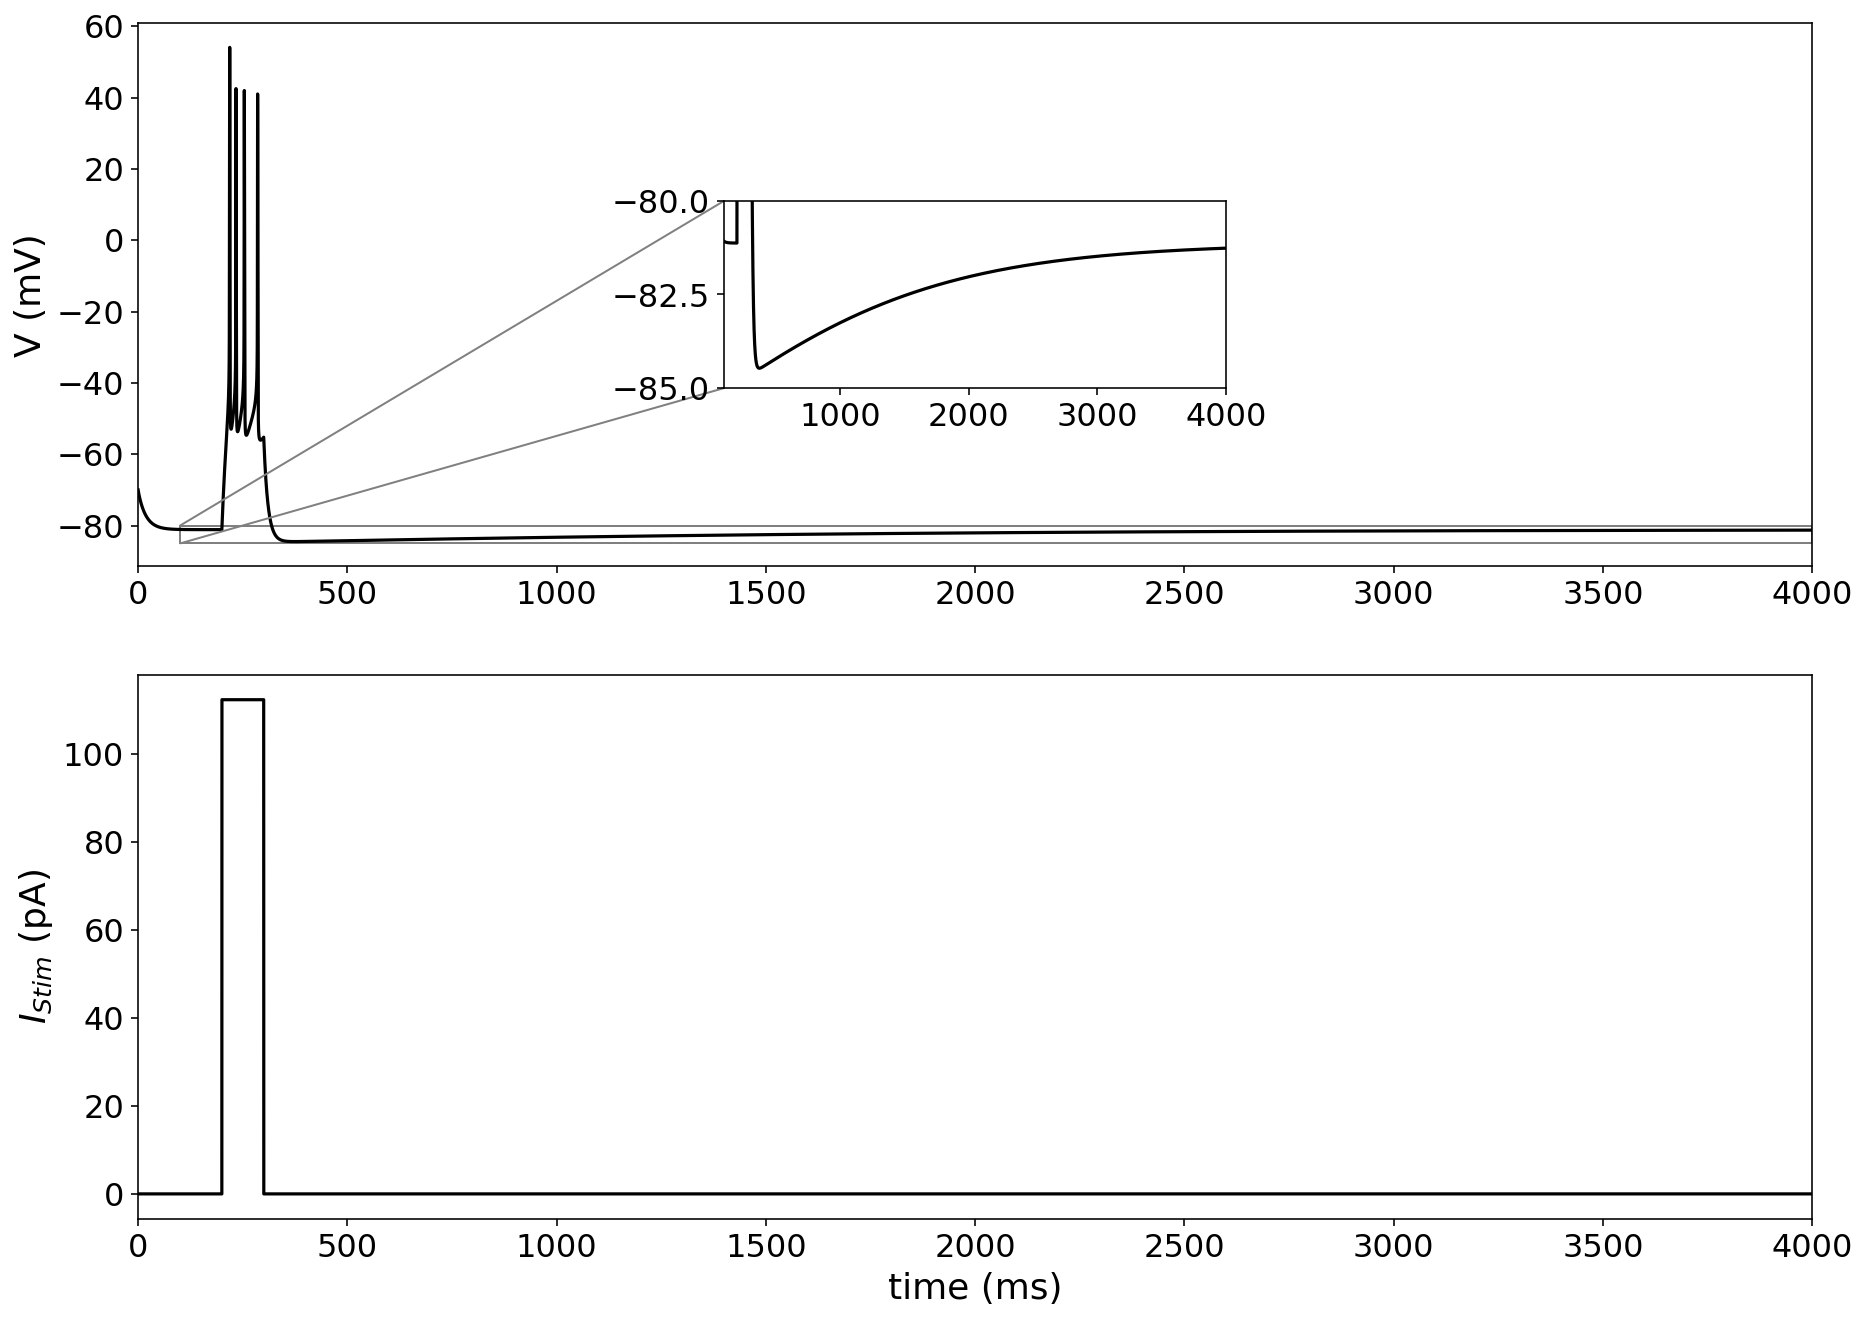

In [90]:
# plot results
ax1=list()
fig1=pl.figure(figsize=(15,11))
pl.ioff()
r=2; c=1
for s in nu.arange(r*c):
    ax1.append(fig1.add_subplot(r,c,s+1))

axins = inset_axes(ax1[0],
                        width="30%", # width = 30% of parent_bbox
                        height=1.3, # height : 1 inch
                        loc=10)
    
ax1[0].plot(nrn.timeSamples, v, 'k', ms=1)
ax1[0].set_ylabel('V (mV)')
ax1[0].set_xlim(0,nrn.timeMax)
#ax1[0].set_ylim(-90,70)

mark_inset(ax1[0], axins, loc1=2, loc2=3, fc="none", ec="0.5")
axins.plot(nrn.timeSamples,nrn.v,'k')
x1, x2, y1, y2 = 100, 4000, -85, -80 # set x and y limits for inset
axins.set_xlim(x1, x2) 
axins.set_ylim(y1, y2) 

ax1[1].plot(nrn.timeSamples,iClamp*1000,'k')
ax1[1].set_ylabel('$I_{Stim}$ (pA)')
ax1[1].set_xlim(0,nrn.timeMax)
#ax1[1].set_ylim(-3,50)
ax1[1].set_xlabel('time (ms)');

To explore the effects of aging on AHPs, we rely on the two previous instances of the class we defined above for young and aged cells, which differ only in the amplitude of their L-type Ca<sup>2+</sup> current. We stimulate the model PCs with a 100ms square pulse current injection to induce a burst of four spikes in both young and aged cells. This required the current amplitude to be increased (iClampAmp 20 units higher) for aged cells. Since the same number of spikes is generated in each cell, their subsequent AHPs can be compared. Note, this may take a little while to run since they are long time windows for two cells. 

In [91]:
# young PC
nrn_y.timeMax = 4000.0;
nrn_y.startIClamp = 200; nrn_y.stopIClamp = 300; nrn_y.iClampAmp=1*75.0; iClamp = nrn_y.IClamp()
v,w,c = nrn_y.RK2_Autonomous(parNames=['A_F',],parValues=[iClamp,])
nrn_y.calcBiophysicsFromDynamics(v,w,c);

# aged (old) PC
nrn_o.timeMax = 4000.0;  
nrn_o.startIClamp = 200; nrn_o.stopIClamp = 300; nrn_o.iClampAmp=1*95.0; iClamp = nrn_o.IClamp()
v,w,c = nrn_o.RK2_Autonomous(parNames=['A_F',],parValues=[iClamp,])
nrn_o.calcBiophysicsFromDynamics(v,w,c);

[ 8000  8001  8002 ... 11997 11998 11999] [0. 0. 0. ... 0. 0. 0.]
Calculating numerical solution
['A_F'] [array([0., 0., 0., ..., 0., 0., 0.])] 1 forcing parameters
nSteps = 160000
[ 8000  8001  8002 ... 11997 11998 11999] [0. 0. 0. ... 0. 0. 0.]
Calculating numerical solution
['A_F'] [array([0., 0., 0., ..., 0., 0., 0.])] 1 forcing parameters
nSteps = 160000


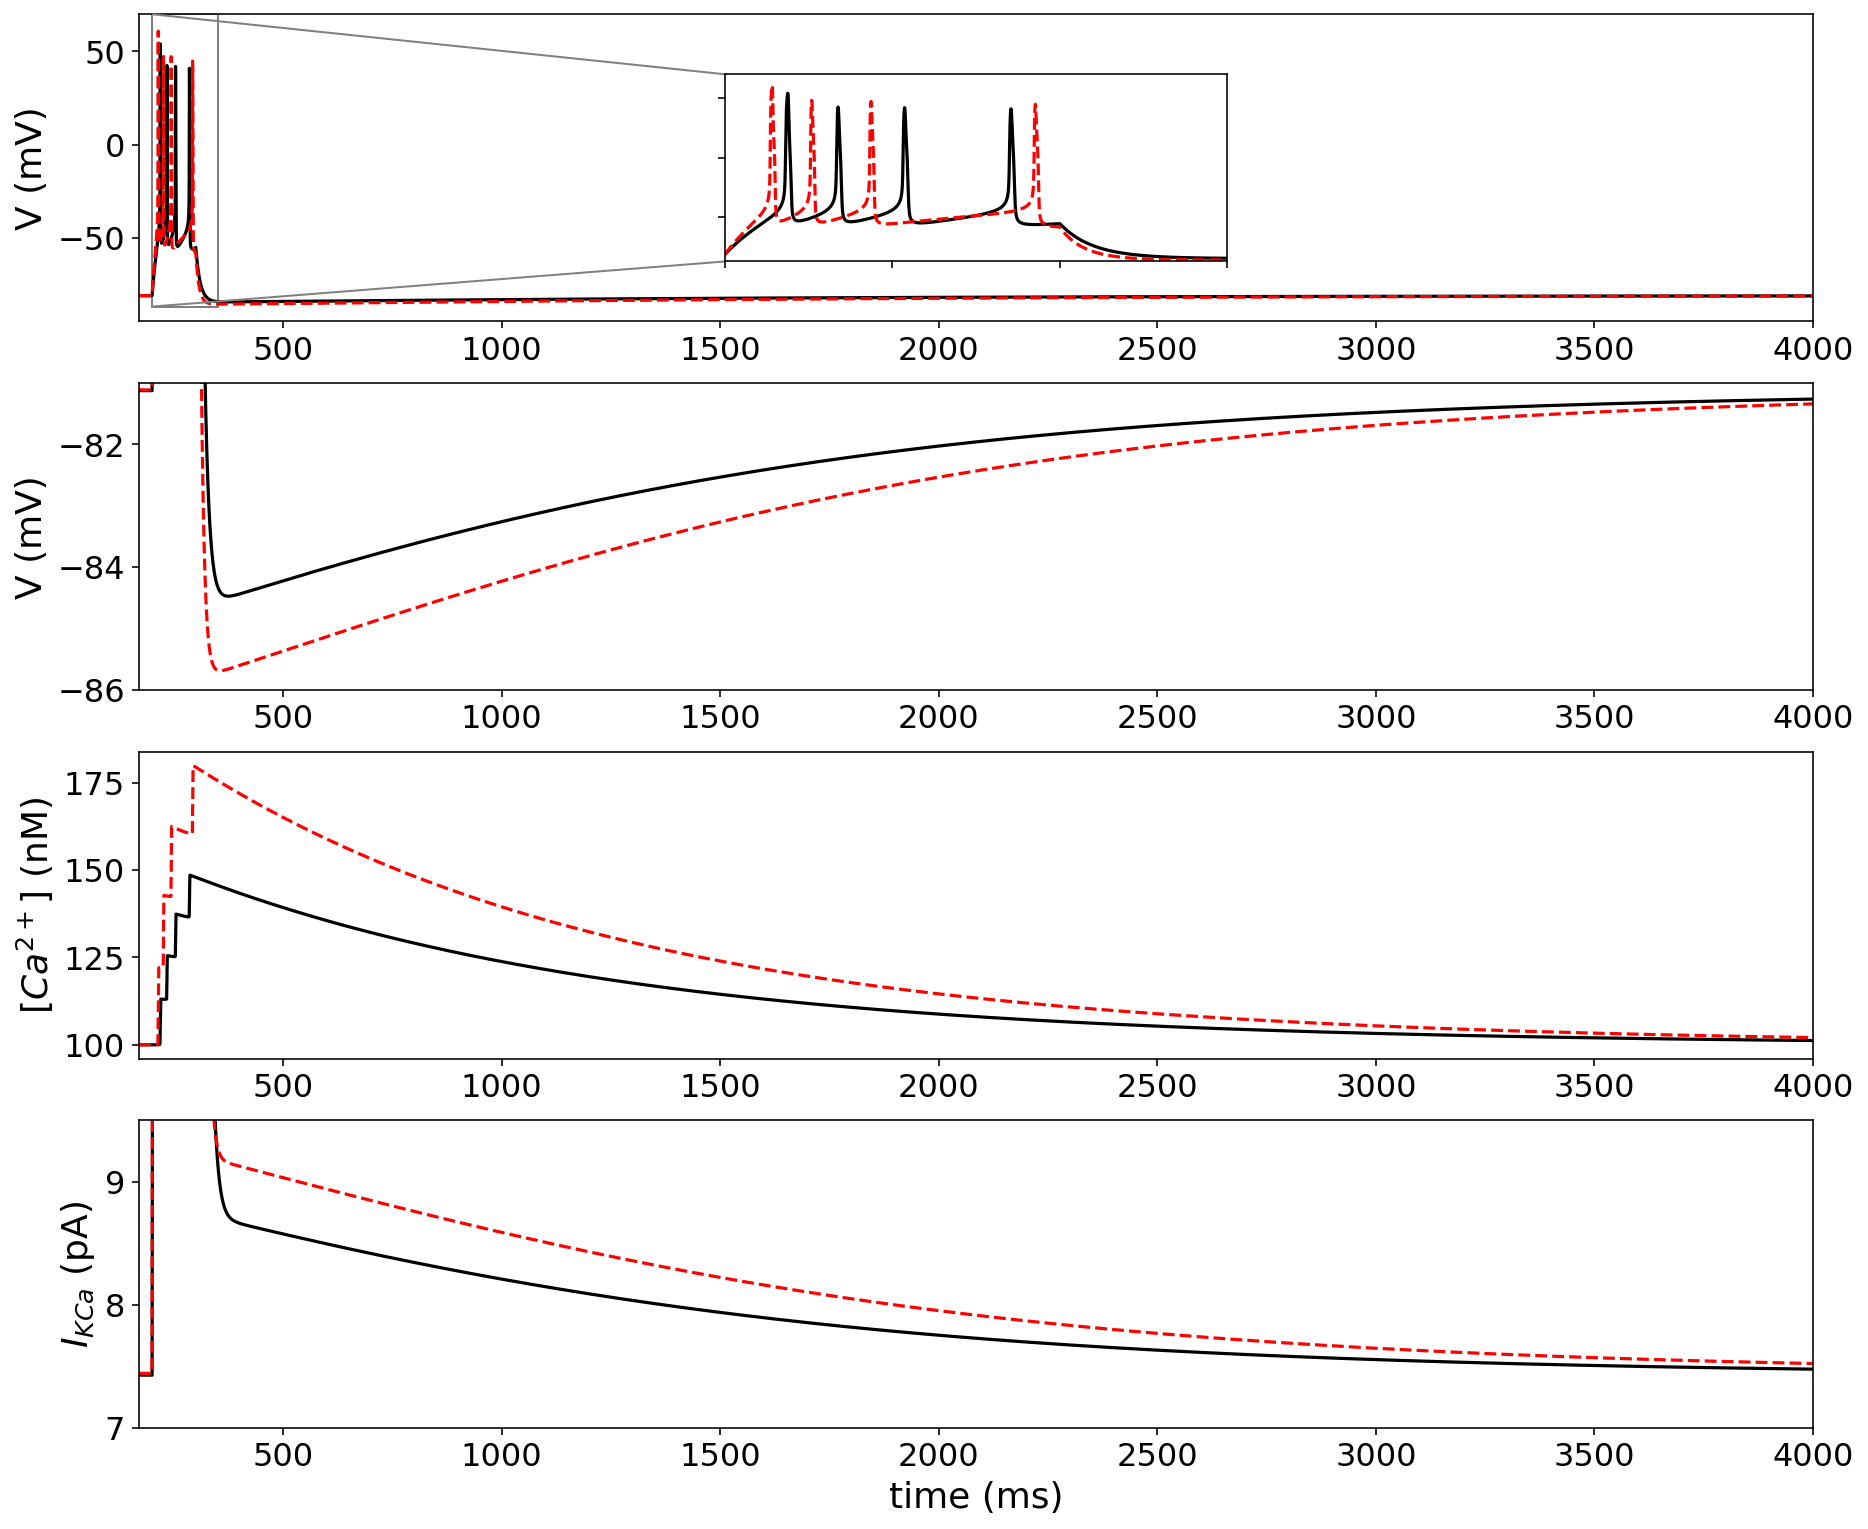

In [92]:
# plot and compare AHPs in young and aged PCs
ax1=list()
fig1=pl.figure(figsize=(15,13))
pl.ioff()
rows=4; cols=1
for s in nu.arange(rows*cols):
    ax1.append(fig1.add_subplot(rows,cols,s+1))
    
axins = inset_axes(ax1[0],
                        width="30%", # width = 30% of parent_bbox
                        height=1.3, # height : 1 inch
                        loc=10)

ax1[0].plot(nrn_y.timeSamples,nrn_y.v,linestyle='solid',color='k')
ax1[0].plot(nrn_o.timeSamples,nrn_o.v,linestyle='dashed',color='r')
ax1[0].set_ylabel('V (mV)')
ax1[0].set_ylim(-95,70)
ax1[0].set_xlim(170,nrn_o.timeMax)
        
mark_inset(ax1[0], axins, loc1=2, loc2=3, fc="none", ec="0.5")
axins.plot(nrn_y.timeSamples,nrn_y.v,linestyle='solid',color='k')
axins.plot(nrn_o.timeSamples,nrn_o.v,linestyle='dashed',color='r')
axins.set_xlim(200,350) 
axins.set_ylim(-87,70) 
pl.yticks(visible=False)
pl.xticks(visible=False)

ax1[1].plot(nrn_y.timeSamples,nrn_y.v,linestyle='solid',color='k')
ax1[1].plot(nrn_o.timeSamples,nrn_o.v,linestyle='dashed',color='r')
ax1[1].set_ylabel('V (mV)')
ax1[1].set_ylim(-86,-81)
ax1[1].set_xlim(170,nrn_o.timeMax)

scale_y2=1e-6
ticks_y=ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y2))
ax1[2].yaxis.set_major_formatter(ticks_y)
ax1[2].plot(nrn_y.timeSamples,nrn_y.c,linestyle='solid',color='k')
ax1[2].plot(nrn_o.timeSamples,nrn_o.c,linestyle='dashed',color='r')
ax1[2].set_xlim(170,nrn_o.timeMax)
ax1[2].set_ylabel('[$Ca^{2+}$] (nM)')

ax1[3].plot(nrn_y.timeSamples,nrn_y.jSK,linestyle='solid',color='k')
ax1[3].plot(nrn_o.timeSamples,nrn_o.jSK,linestyle='dashed',color='r')
ax1[3].set_xlabel('time (ms)')
ax1[3].set_ylabel('$I_{KCa}$ (pA)')
ax1[3].set_xlim(170,nrn_o.timeMax)
ax1[3].set_ylim(7,9.5); 

AHPs are observed in both young and aged model PCs, and with relative magnitudes similar to those observed in recordings. The increase in the Ca<sup>2+</sup> channel expression in aged model PCs is sufficient to produce larger AHPs than seen in young PCs. 

### Conditional bursting
Experiments show that some CA1 PCs burst in response to current injection, a behavior known as conditional bursting because the cells only display this behavior in response to a stimulus. To reproduce this behavior in the model, we increased the amplitude of the Na<sup>+</sup> and SK currents, decreased the delayed rectifier K<sup>+</sup> current, and increased the rate of K<sup>+</sup> channel activation. We also altered the Ca<sup>2+</sup> handling. (See main article for more details.) 

In [93]:
# use original nrn class, change only necessary parameters 
nrn.a_NaT = 1300; 
nrn.a_NaK = nrn.a_NaT/100; 
nrn.a_DK = 6000; 
nrn.a_CaL = 25; 
nrn.a_SK = 1600; 
#
nrn.r_in_Ca = 5e-3;
nrn.r_Act_DK = 1.8;
nrn.r_conv_Ca = 6e-6; 
#
nrn.reparametrize()
nrn.v0 = -70.0; nrn.w0 = 0.001; nrn.c0=1e-4;
nrn.timeMax = 2000.0;  nrn.timeStep = 1.0/40.0;
nrn.startIClamp = 200; nrn.stopIClamp = 1000; nrn.iClampAmp=1*65.0; iClamp = nrn.IClamp()
v,w,c = nrn.RK2_Autonomous(parNames=['A_F',],parValues=[iClamp,])
nrn.calcBiophysicsFromDynamics(v,w,c);

A_NaK = 0.0389123, A_DK = 17.9595, A_SK = 4.7892, A_NaT = 3.89123, A_CaL = 0.149663,         all in V/s
a_NaK = 13, a_DK = 6000, a_SK = 1600, a_NaT = 1300, a_CaL = 25,         all in pA
[ 8000  8001  8002 ... 39997 39998 39999] [0. 0. 0. ... 0. 0. 0.]
Calculating numerical solution
['A_F'] [array([0., 0., 0., ..., 0., 0., 0.])] 1 forcing parameters
nSteps = 80000


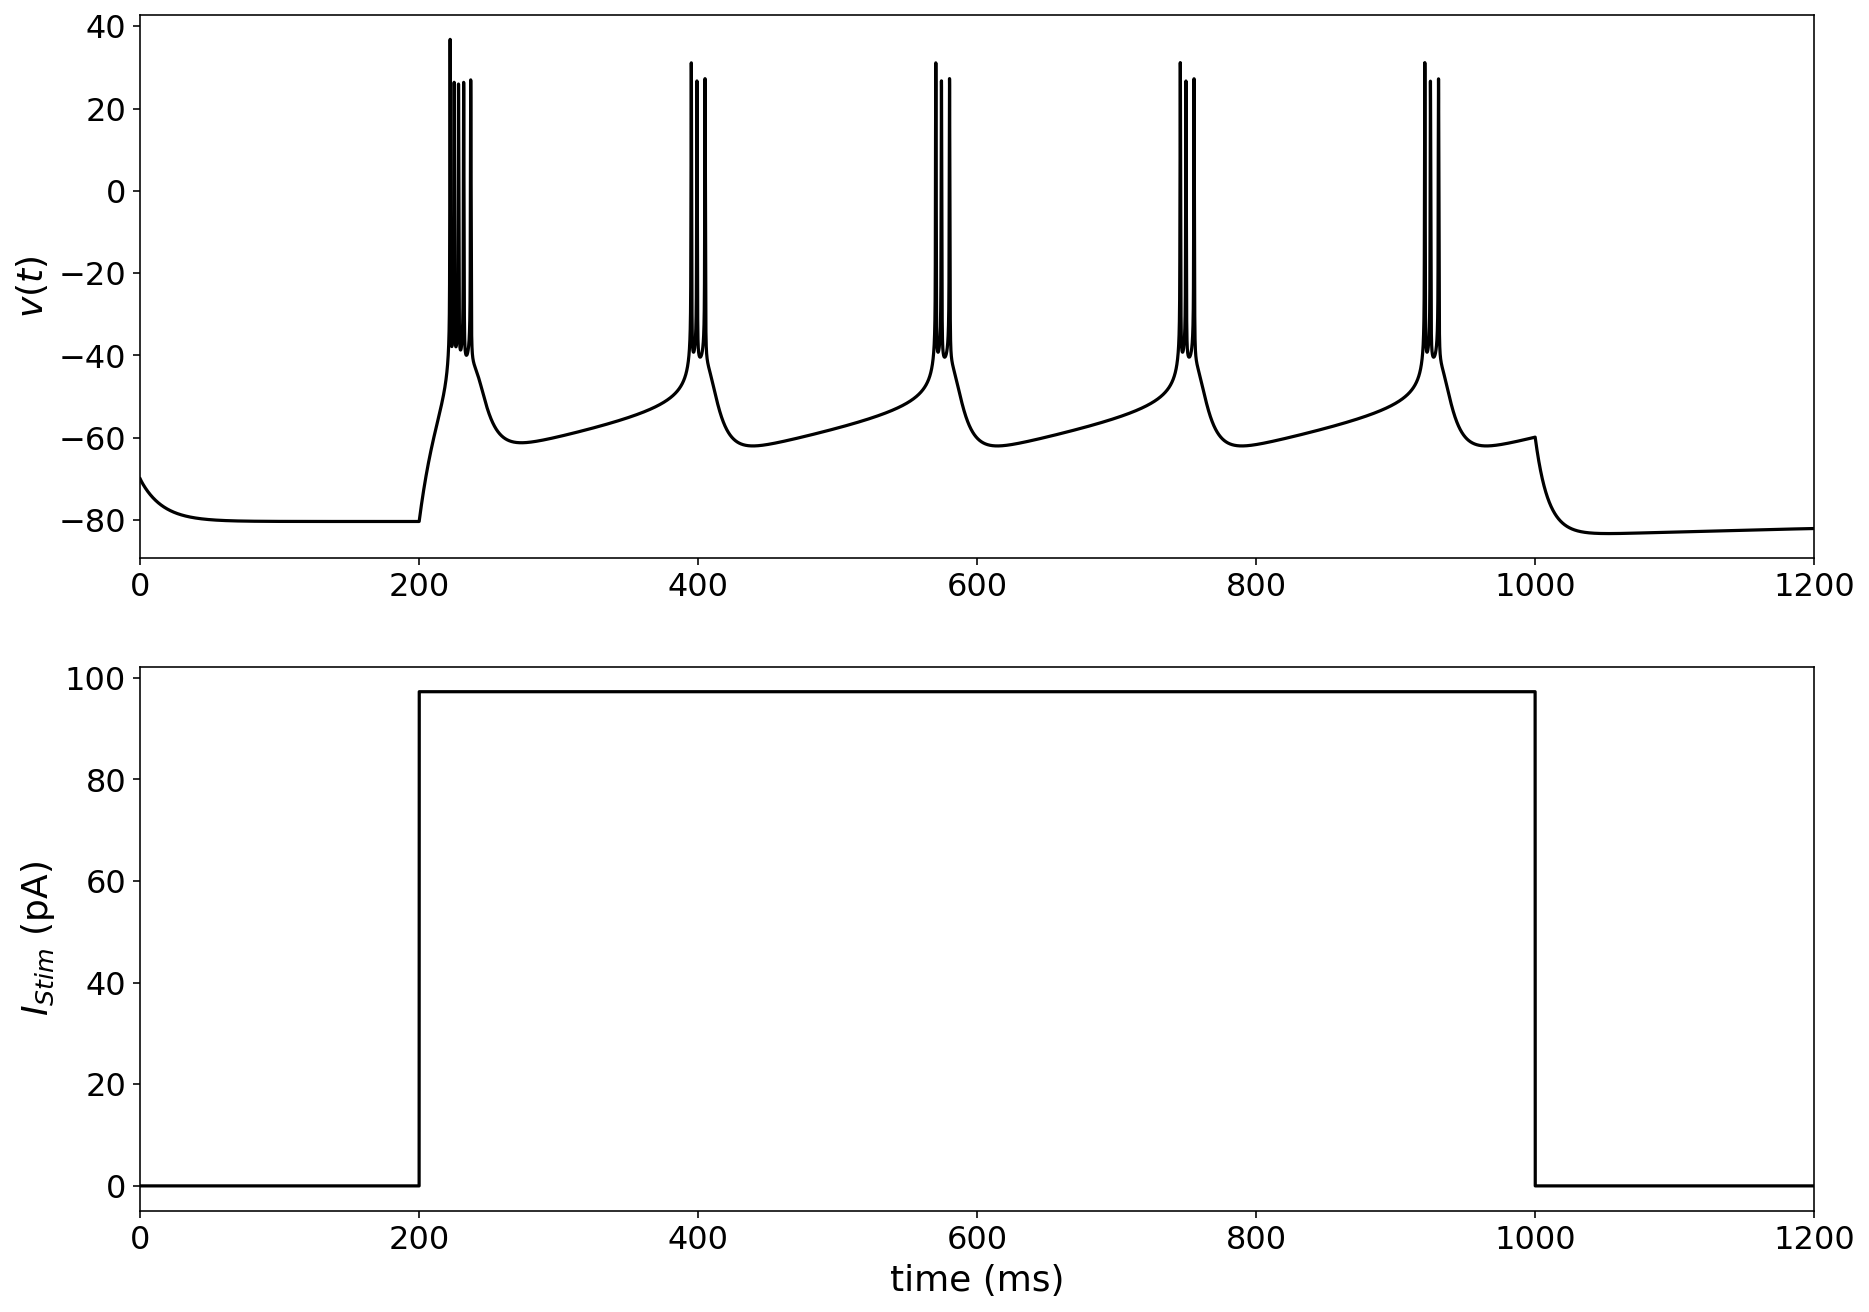

In [94]:
# plot results
ax1=list()
fig1=pl.figure(figsize=(15,11))
pl.ioff()
rows=2; cols=1
for s in nu.arange(rows*cols):
    ax1.append(fig1.add_subplot(rows,cols,s+1))

ax1[0].plot(nrn.timeSamples, v, 'k', ms=1)
ax1[0].set_ylabel(r'$v(t)$')
ax1[0].set_xlim(0,1200)
#ax1[0].set_ylim(-90,70)
 
ax1[1].plot(nrn.timeSamples,iClamp*1000,'k')
ax1[1].set_ylabel('$I_{Stim}$ (pA)')
ax1[1].set_xlim(0,1200)
#ax1[1].set_ylim(-3,50)
ax1[1].set_xlabel('time (ms)');

As before, we can zoom in on the activity and plot the different ion currents to see their dynamics and amplitudes during bursting. Depending on what we want to observe, we can change the x and y limits (some currents are much larger than others).

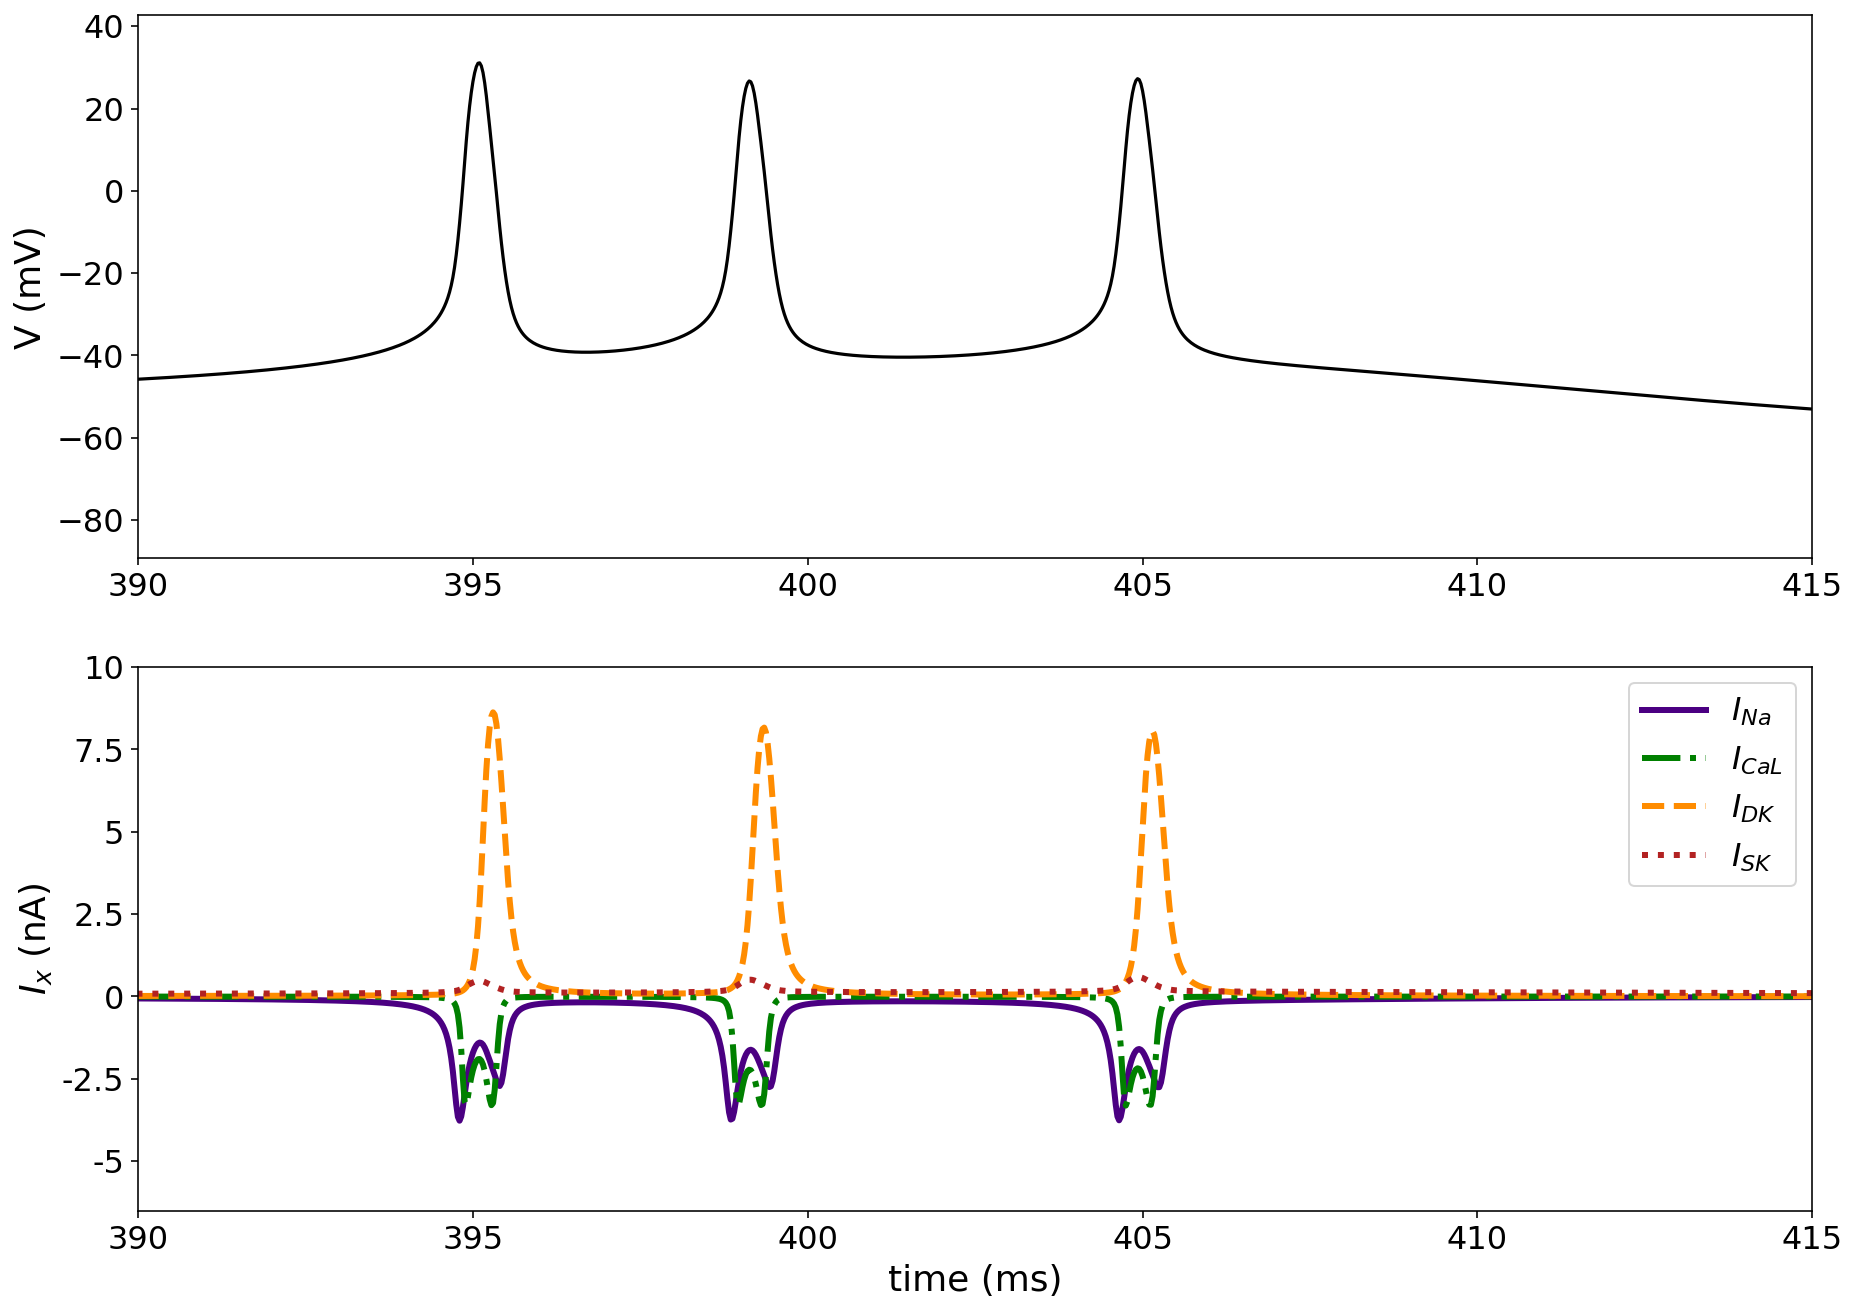

In [96]:
# plot just a few spikes from above simulation and currents
ax1=list()
fig1=pl.figure(figsize=(15,11))
pl.ioff()
rows=2; cols=1
for s in nu.arange(rows*cols):
    ax1.append(fig1.add_subplot(rows,cols,s+1))

ax1[0].plot(nrn.timeSamples, v,'k')
ax1[0].set_ylabel('V (mV)')
ax1[0].set_xlim(390,415)

ticks_y=ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1000))
ax1[1].yaxis.set_major_formatter(ticks_y)
ax1[1].plot(nrn.timeSamples, nrn.jNaT, linestyle='solid', linewidth=3.0, color='indigo', label=r'$I_{Na}$')
ax1[1].plot(nrn.timeSamples, nrn.jCaL, linestyle='dashdot', linewidth=3.0, color='green', label=r'$I_{CaL}$')
ax1[1].plot(nrn.timeSamples, nrn.jDK, linestyle='dashed', linewidth=3.0, color='darkorange', label=r'$I_{DK}$')
ax1[1].plot(nrn.timeSamples, nrn.jSK, linestyle='dotted', linewidth=3.0, color='firebrick', label=r'$I_{SK}$')
#ax1[1].plot(nrn.timeSamples, nrn.jNaK, label=r'$I_{NaK}$')
ax1[1].set_xlabel('time (ms)')
ax1[1].set_ylabel('$I_{x}$ (nA)')
ax1[1].set_xlim(390,415)
ax1[1].set_ylim(-6500,10000)
ax1[1].legend(loc="upper right");

To compare the responses of young and aged PCs, we vary the Ca<sup>2+</sup> channel amplitude as before. Just to be safe, we'll reestablish the class instances for young and aged PCs, and then change the necessary parameters to produce conditional bursting. 

In [97]:
# young PC
nrn_y = pyrCA1(pars)
nrn_y.a_NaT = 1300; 
nrn_y.a_NaK = nrn_y.a_NaT/100; 
nrn_y.a_DK = 6000; 
nrn_y.a_CaL = 25; 
nrn_y.a_SK = 1600; 
nrn_y.r_in_Ca = 5e-3;
nrn_y.r_Act_DK = 1.8;
nrn_y.r_conv_Ca = 6e-6; 
#
nrn_y.reparametrize()
nrn_y.startIClamp = 200; nrn_y.stopIClamp = 1000; nrn_y.iClampAmp=1*65.0; iClamp = nrn_y.IClamp()
v,w,c = nrn_y.RK2_Autonomous(parNames=['A_F',],parValues=[iClamp,])
nrn_y.calcBiophysicsFromDynamics(v,w,c)

# aged (old) PC
nrn_o = pyrCA1(pars)
nrn_o.a_NaT = 1300; 
nrn_o.a_NaK = nrn_o.a_NaT/100; 
nrn_o.a_DK = 6000; 
nrn_o.a_CaL = 50; 
nrn_o.a_SK = 1600; 
nrn_o.r_in_Ca = 5e-3;
nrn_o.r_Act_DK = 1.8;
nrn_o.r_conv_Ca = 6e-6; 
#
nrn_o.reparametrize()
nrn_o.startIClamp = 200; nrn_o.stopIClamp = 1000; nrn_o.iClampAmp=1*65.0; iClamp = nrn_o.IClamp()
v,w,c = nrn_o.RK2_Autonomous(parNames=['A_F',],parValues=[iClamp,])
nrn_o.calcBiophysicsFromDynamics(v,w,c);

A_NaK = 0.0299325, A_DK = 23.946, A_SK = 4.19055, A_NaT = 2.99325, A_CaL = 0.149663,         all in V/s
a_NaK = 10, a_DK = 8000, a_SK = 1400, a_NaT = 1000, a_CaL = 25,         all in pA
A_NaK = 0.0389123, A_DK = 17.9595, A_SK = 4.7892, A_NaT = 3.89123, A_CaL = 0.149663,         all in V/s
a_NaK = 13, a_DK = 6000, a_SK = 1600, a_NaT = 1300, a_CaL = 25,         all in pA
[ 8000  8001  8002 ... 39997 39998 39999] [0. 0. 0. ... 0. 0. 0.]
Calculating numerical solution
['A_F'] [array([0., 0., 0., ..., 0., 0., 0.])] 1 forcing parameters
nSteps = 48000
A_NaK = 0.0299325, A_DK = 23.946, A_SK = 4.19055, A_NaT = 2.99325, A_CaL = 0.149663,         all in V/s
a_NaK = 10, a_DK = 8000, a_SK = 1400, a_NaT = 1000, a_CaL = 25,         all in pA
A_NaK = 0.0389123, A_DK = 17.9595, A_SK = 4.7892, A_NaT = 3.89123, A_CaL = 0.299325,         all in V/s
a_NaK = 13, a_DK = 6000, a_SK = 1600, a_NaT = 1300, a_CaL = 50,         all in pA
[ 8000  8001  8002 ... 39997 39998 39999] [0. 0. 0. ... 0. 0. 0.]
Calculatin

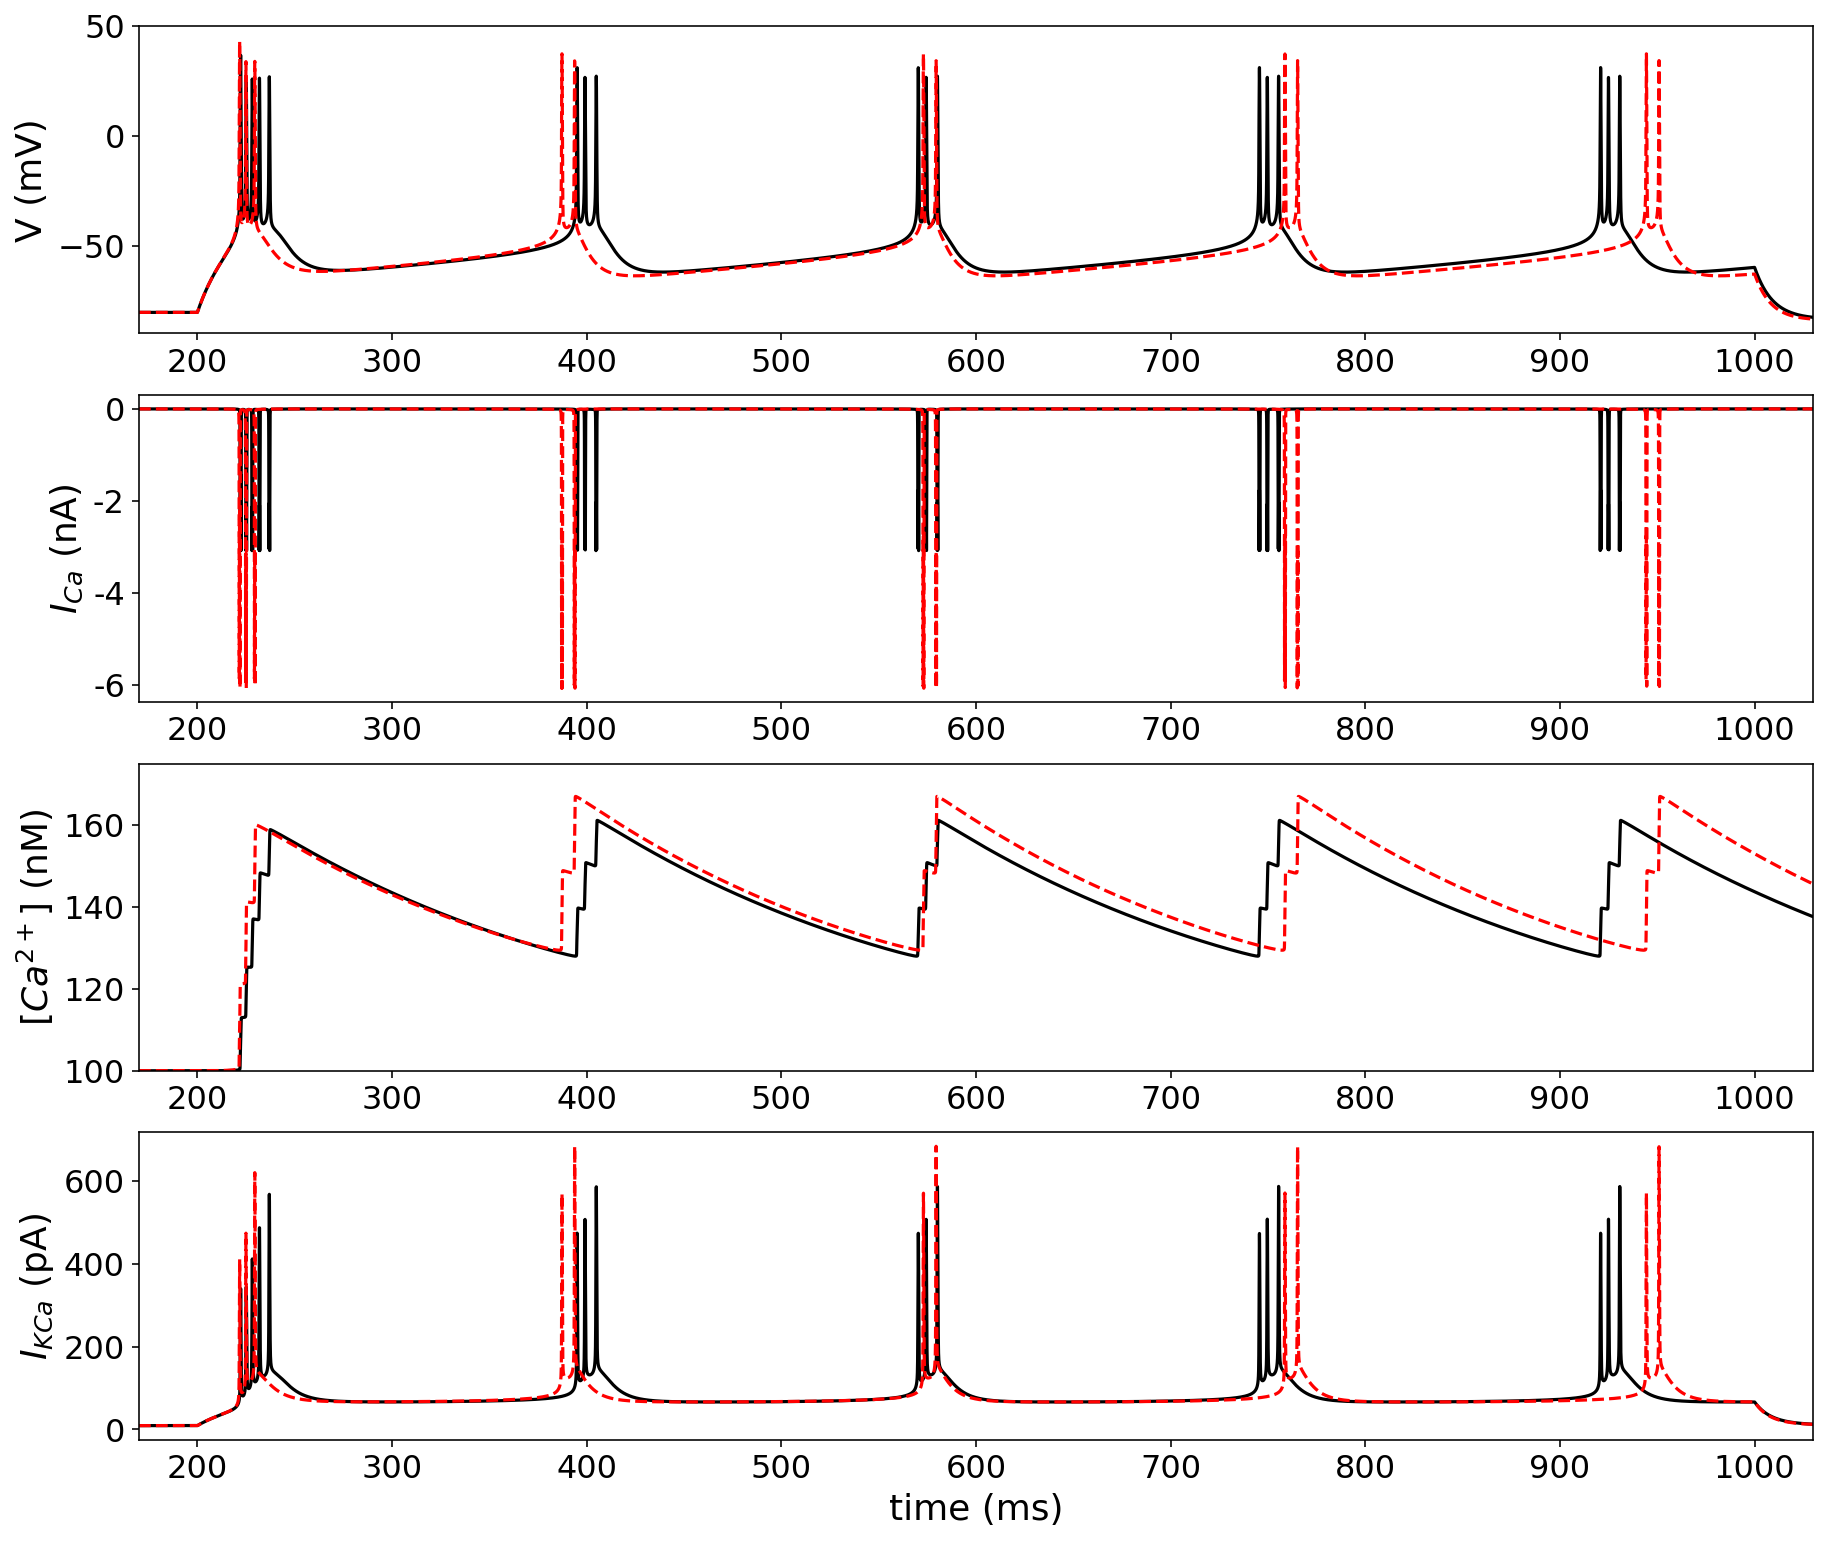

In [98]:
# plot and compare bursting in young and aged PCs
ax1=list()
fig1=pl.figure(figsize=(15,13))
pl.ioff()
rows=4; cols=1
for s in nu.arange(rows*cols):
    ax1.append(fig1.add_subplot(rows,cols,s+1))
    
ax1[0].plot(nrn_y.timeSamples,nrn_y.v,linestyle='solid',color='k')
ax1[0].plot(nrn_o.timeSamples,nrn_o.v,linestyle='dashed',color='r')
ax1[0].set_ylabel('V (mV)')
ax1[0].set_ylim(-90,50)
ax1[0].set_xlim(170,1030)
        
ticks_y=ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1000))
ax1[1].yaxis.set_major_formatter(ticks_y)
ax1[1].plot(nrn_y.timeSamples,nrn_y.jCaL,linestyle='solid',color='k')
ax1[1].plot(nrn_o.timeSamples,nrn_o.jCaL,linestyle='dashed',color='r')
ax1[1].set_ylabel('$I_{Ca}$ (nA)')
ax1[1].set_xlim(170,1030)

scale_y2=1e-6
ticks_y=ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y2))
ax1[2].yaxis.set_major_formatter(ticks_y)
ax1[2].plot(nrn_y.timeSamples,nrn_y.c,linestyle='solid',color='k')
ax1[2].plot(nrn_o.timeSamples,nrn_o.c,linestyle='dashed',color='r')
ax1[2].set_xlim(170,1030)
ax1[2].set_ylim(1e-4,1.75e-4)
ax1[2].set_ylabel('[$Ca^{2+}$] (nM)')

ax1[3].plot(nrn_y.timeSamples,nrn_y.jSK,linestyle='solid',color='k')
ax1[3].plot(nrn_o.timeSamples,nrn_o.jSK,linestyle='dashed',color='r')
ax1[3].set_xlabel('time (ms)')
ax1[3].set_ylabel('$I_{KCa}$ (pA)')
ax1[3].set_xlim(170,1030);

Due to the increased Ca<sup>2+</sup> entry, aged PCs initially burst earlier than young PCs. However, they fire fewer spikes per burst. As intracellular Ca<sup>2+</sup> increases and stays elevated, inducing a larger SK current, the activity of the aged PC slows and falls behind the young PC. 

However, responses can vary depending on the stimulation. Now, we compare the responses of young and aged PCs to different stimulus amplitudes, ranging from 50 to 170 pA. Note, this simulation can take some time due to running multiple stimulation amplitudes for two cells.

In [99]:
"""
Remember that to calculate the final stimulation amplitudes, divide iClampAmp by vTCm and multiple by 1000 to get pA. 
For ease, we've set it up to do the calculation here, and you can see both the iClamp stimulation values 
(stims) and the values converted into pA (convs).
"""
#stims=nu.arange(35,150,25)
stims=(34,54,74,94,114) # these are the iClampAmp values that go into the iClamp protocol
convs=list()
for i in stims:
    amp=int((i/nrn.vTCm)*1000) 
    convs.append(amp)
nstims=len(stims)
print(convs) # these are the converted stimulation amplitudes in pA

[50, 80, 110, 140, 170]


In [100]:
simsy = list()
simso = list()

for i in range(nstims):
    # young PC
    nrn_y.iClampAmp=stims[i]; iClamp = nrn_y.IClamp()
    v,w,c = nrn_y.RK2_Autonomous(parNames=['A_F',],parValues=[iClamp,]);
    oo=nrn_y.calcBiophysicsFromDynamics(v,w,c);
    simsy.append(oo);
    # aged (old) PC
    nrn_o.iClampAmp=stims[i]; iClamp = nrn_o.IClamp()
    v,w,c = nrn_o.RK2_Autonomous(parNames=['A_F',],parValues=[iClamp,]);
    oo=nrn_o.calcBiophysicsFromDynamics(v,w,c);
    simso.append(oo);

[ 8000  8001  8002 ... 39997 39998 39999] [0. 0. 0. ... 0. 0. 0.]
Calculating numerical solution
['A_F'] [array([0., 0., 0., ..., 0., 0., 0.])] 1 forcing parameters
nSteps = 48000
[ 8000  8001  8002 ... 39997 39998 39999] [0. 0. 0. ... 0. 0. 0.]
Calculating numerical solution
['A_F'] [array([0., 0., 0., ..., 0., 0., 0.])] 1 forcing parameters
nSteps = 48000
[ 8000  8001  8002 ... 39997 39998 39999] [0. 0. 0. ... 0. 0. 0.]
Calculating numerical solution
['A_F'] [array([0., 0., 0., ..., 0., 0., 0.])] 1 forcing parameters
nSteps = 48000
[ 8000  8001  8002 ... 39997 39998 39999] [0. 0. 0. ... 0. 0. 0.]
Calculating numerical solution
['A_F'] [array([0., 0., 0., ..., 0., 0., 0.])] 1 forcing parameters
nSteps = 48000
[ 8000  8001  8002 ... 39997 39998 39999] [0. 0. 0. ... 0. 0. 0.]
Calculating numerical solution
['A_F'] [array([0., 0., 0., ..., 0., 0., 0.])] 1 forcing parameters
nSteps = 48000
[ 8000  8001  8002 ... 39997 39998 39999] [0. 0. 0. ... 0. 0. 0.]
Calculating numerical solution
['A

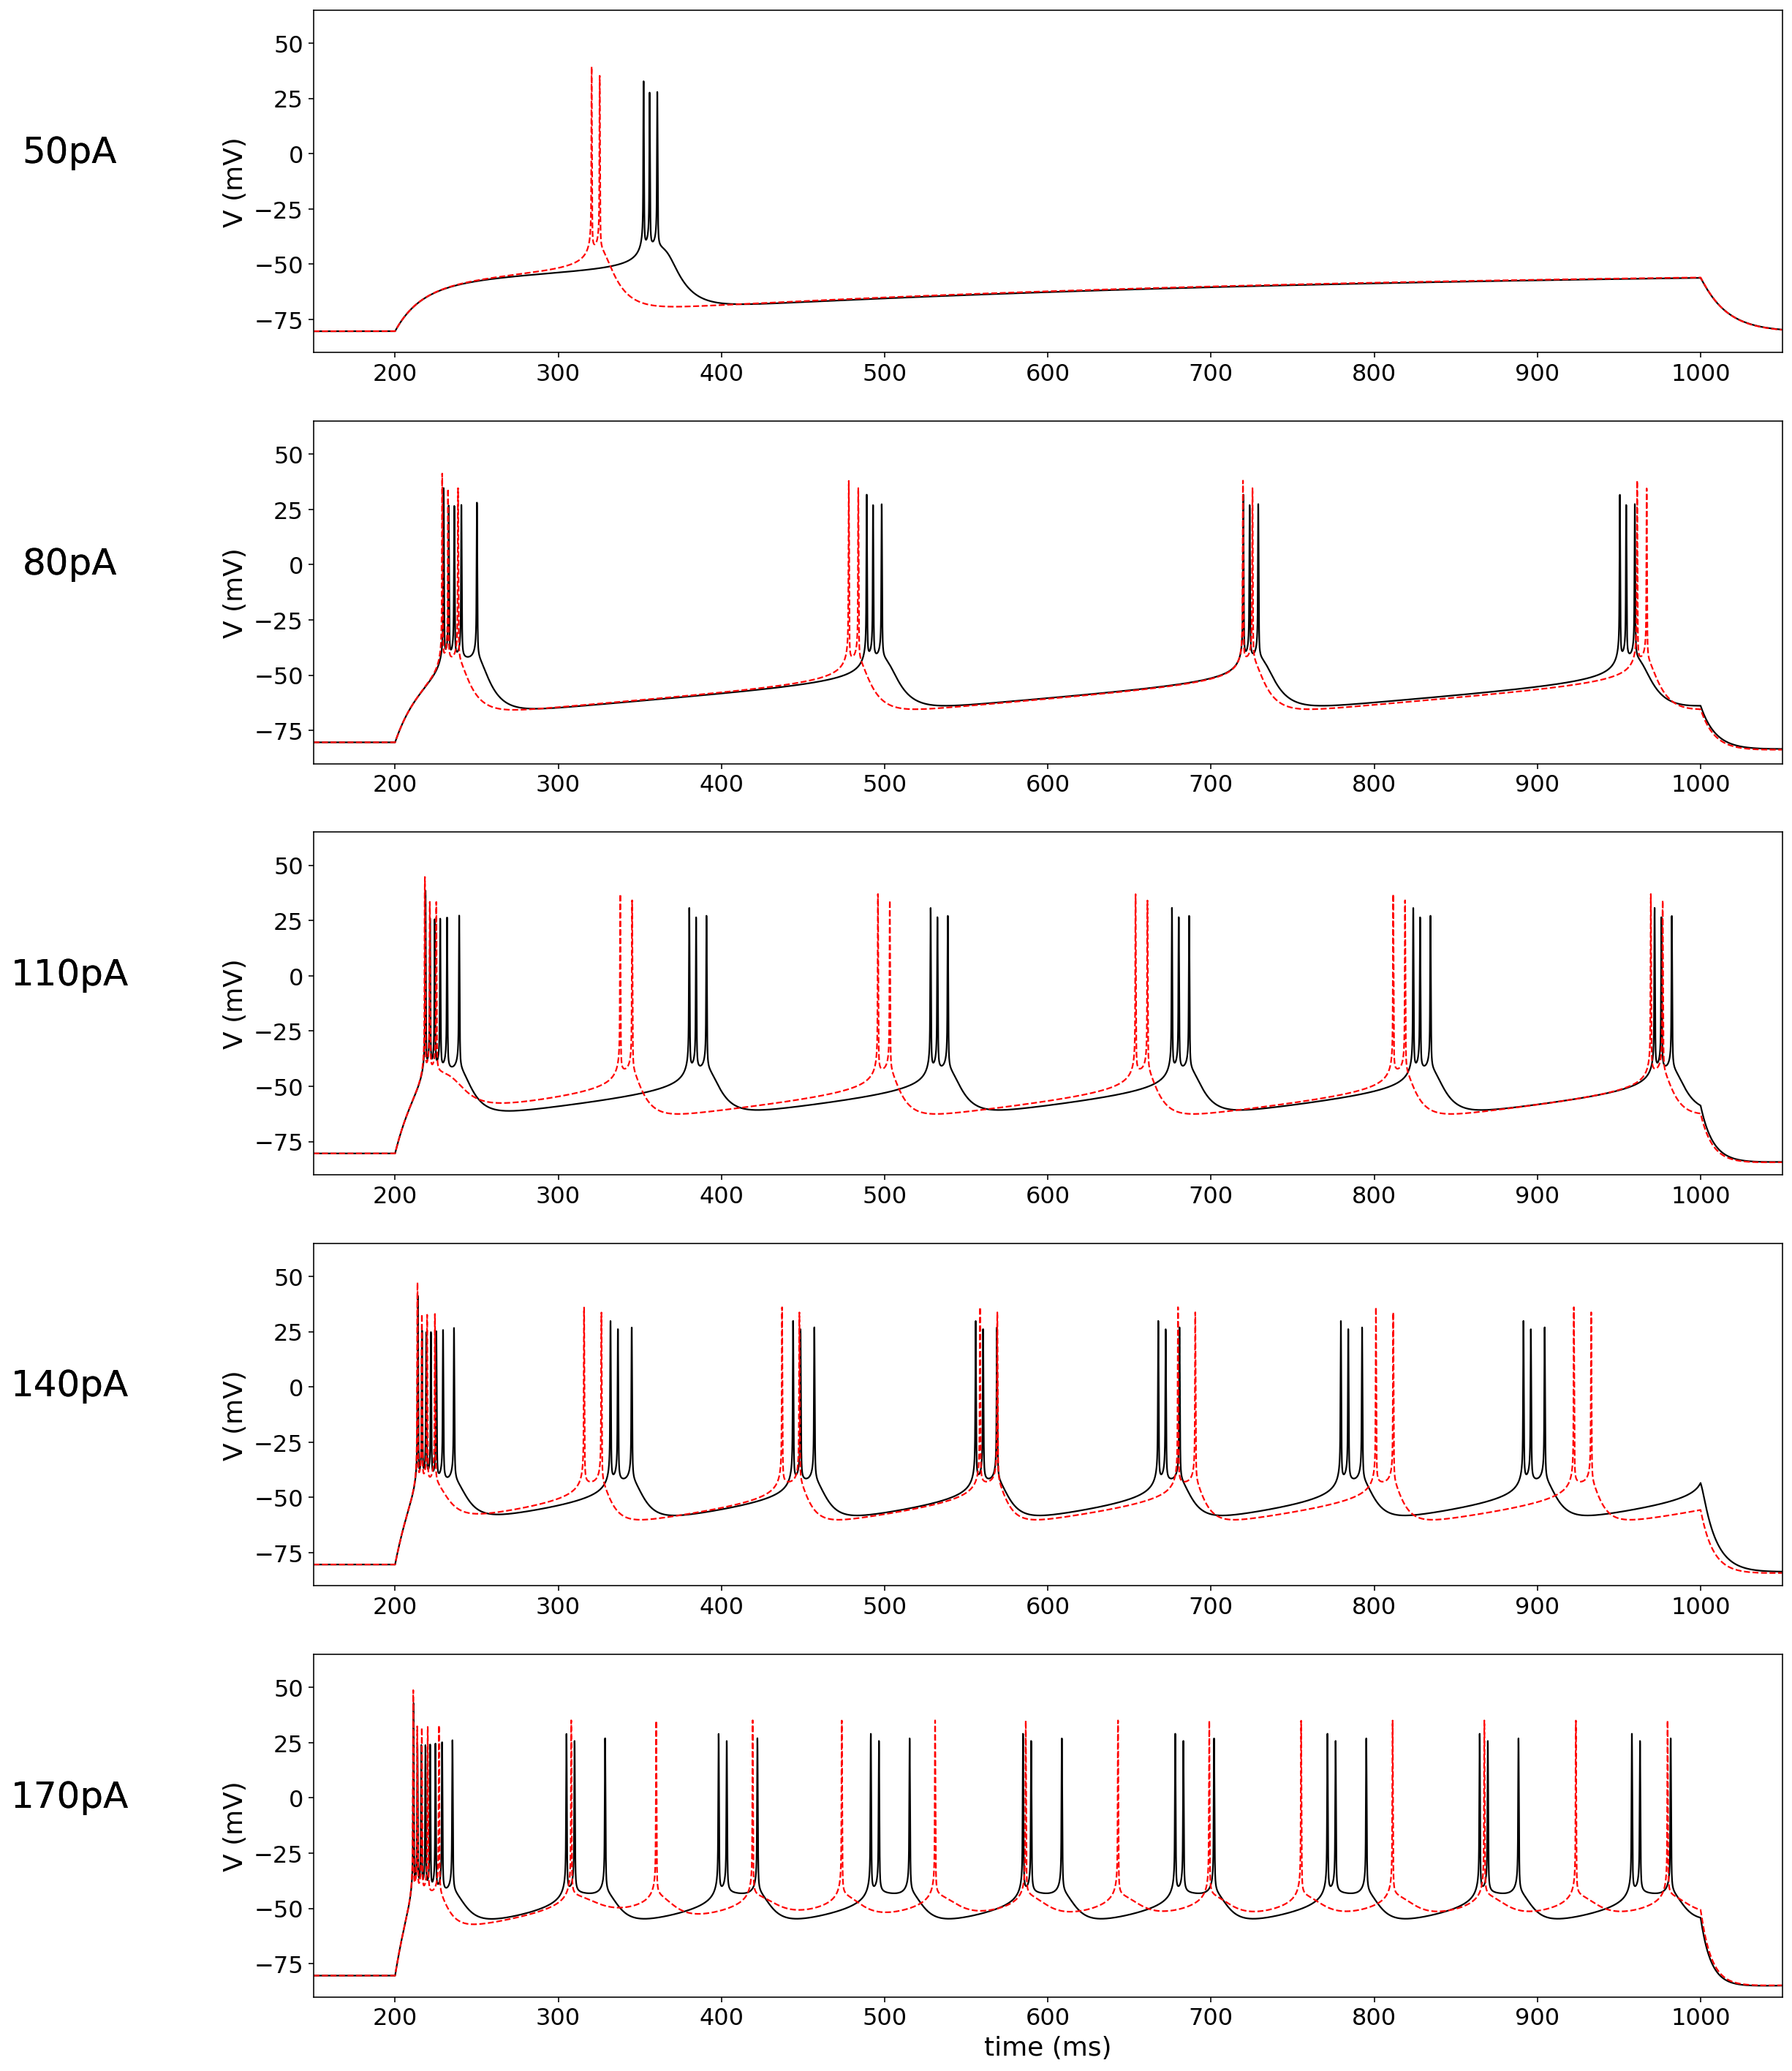

In [101]:
# plot the results of the above simulations 
ax1=list()
fig1=pl.figure(figsize=(18,25))
pl.rcParams['lines.linewidth'] = 1.1
pl.ioff()
rows=nstims; cols=1
for s in nu.arange(rows*cols):
    ax1.append(fig1.add_subplot(rows,cols,s+1))

for i in range(nstims):
    # plot young PC activity
    ax1[i].plot(nrn_y.timeSamples,simsy[i][0],linestyle='solid',color='k')
    ax1[i].text(0.5, 0.5,'%g'%(convs[i])+'pA',horizontalalignment='center', verticalalignment='center',size=25)
    ax1[i].set_ylabel('V (mV)')
    ax1[i].set_ylim(-90,65)
    ax1[i].set_xlim(150,1050)
    # plot aged PC activity
    ax1[i].plot(nrn_o.timeSamples,simso[i][0],linestyle='dashed',color='r')
    ax1[i].text(0.5, 0.5,'%g'%(convs[i])+'pA',horizontalalignment='center', verticalalignment='center',size=25)
    ax1[i].set_ylabel('V (mV)')
    ax1[i].set_ylim(-90,65)
    ax1[i].set_xlim(150,1050)
    
pl.xlabel('time (ms)');

### Spontaneous bursting
Experiments have shown that some CA1 pyramidal cells burst spontaneously in the absence of any current injection. To reproduce this firing behavior, we lowered the Na<sup>+</sup>, delayed rectifier K<sup>+</sup>, and SK channel amplitudes, as well as the rate of activation for the delayed rectifier channel. We also altered the Ca<sup>2+</sup> handling. Note that the stimulation amplitude is set to 0 pA.

In [110]:
nrn.a_NaT = 2300; 
nrn.a_NaK = nrn.a_NaT/100; 
nrn.a_DK = 7000;  
nrn.a_CaL = 25; 
nrn.a_SK = 300;  
nrn.r_in_Ca = 5e-3; 
nrn.r_Act_DK = 1.1; 
nrn.r_conv_Ca = 6e-6; 

#
nrn.reparametrize()
nrn.v0 = -70.0; nrn.w0 = 0.001; nrn.c0=1e-4;
nrn.timeMax = 4000.0;  nrn.timeStep = 1.0/40.0; 
nrn.startIClamp = 200; nrn.stopIClamp = 1000; nrn.iClampAmp=0*10.0; iClamp = nrn.IClamp()
v,w,c = nrn.RK2_Autonomous(parNames=['A_F',],parValues=[iClamp,])
nrn.calcBiophysicsFromDynamics(v,w,c);

A_NaK = 0.0688448, A_DK = 20.9528, A_SK = 0.897975, A_NaT = 6.88448, A_CaL = 0.149663,         all in V/s
a_NaK = 23, a_DK = 7000, a_SK = 300, a_NaT = 2300, a_CaL = 25,         all in pA
[ 8000  8001  8002 ... 39997 39998 39999] [0. 0. 0. ... 0. 0. 0.]
Calculating numerical solution
['A_F'] [array([0., 0., 0., ..., 0., 0., 0.])] 1 forcing parameters
nSteps = 160000


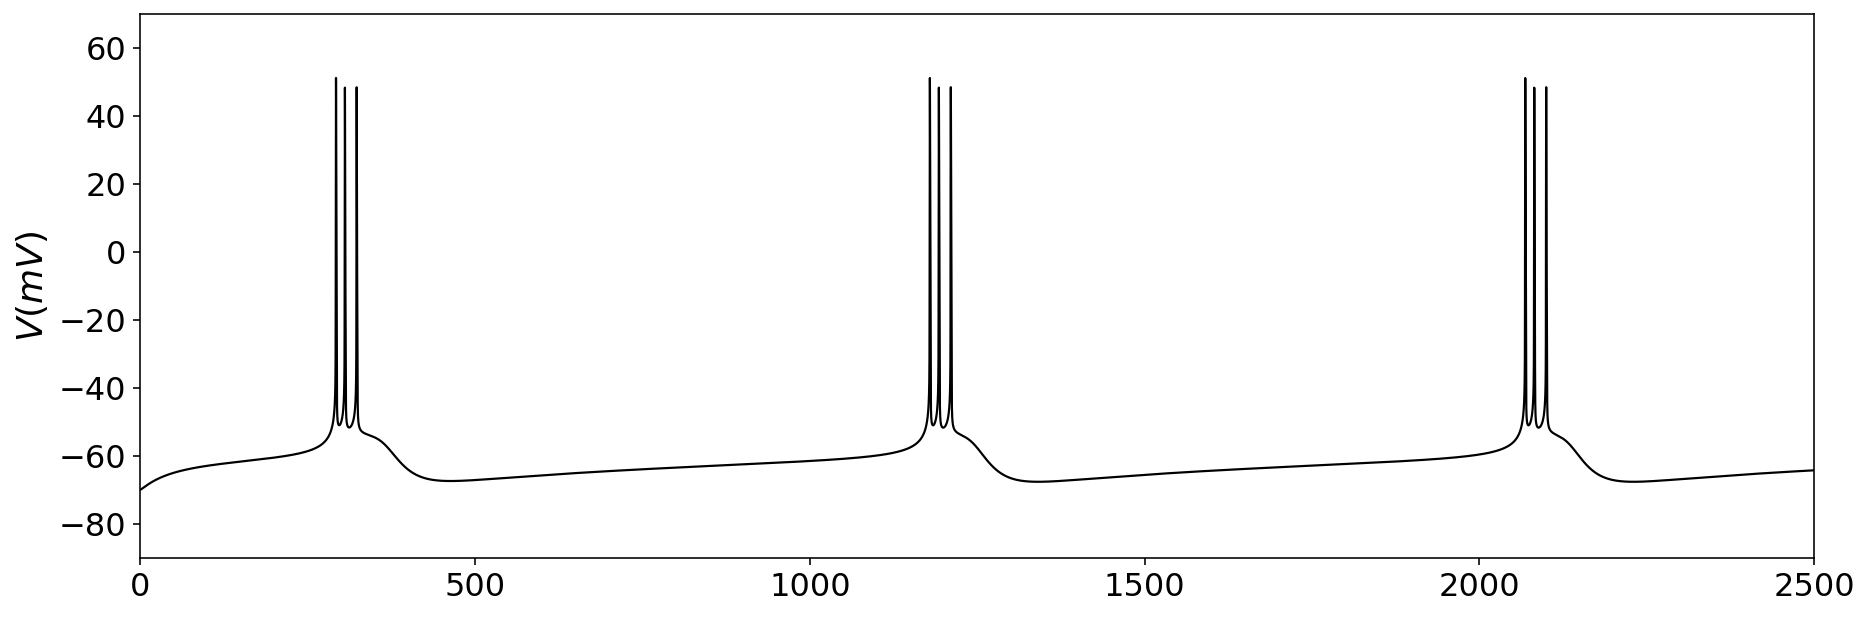

In [111]:
ax1=list()
fig1=pl.figure(figsize=(15,5))
pl.ioff()
rows=1; cols=1
for s in nu.arange(rows*cols):
    ax1.append(fig1.add_subplot(rows,cols,s+1))

ax1[0].plot(nrn.timeSamples, v, 'k', ms=1)
ax1[0].set_ylabel(r'$V(mV)$')
ax1[0].set_xlim(0,2500)
ax1[0].set_ylim(-90,70);

# uncomment to plot stimulus
#ax1[1].plot(nrn.timeSamples,iClamp,'k')
#ax1[1].set_ylabel('$I_{Stim}$ (pA)')
#ax1[1].set_xlim(0,2500)
#ax1[1].set_ylim(-3,50)
#ax1[1].set_xlabel('time (ms)');

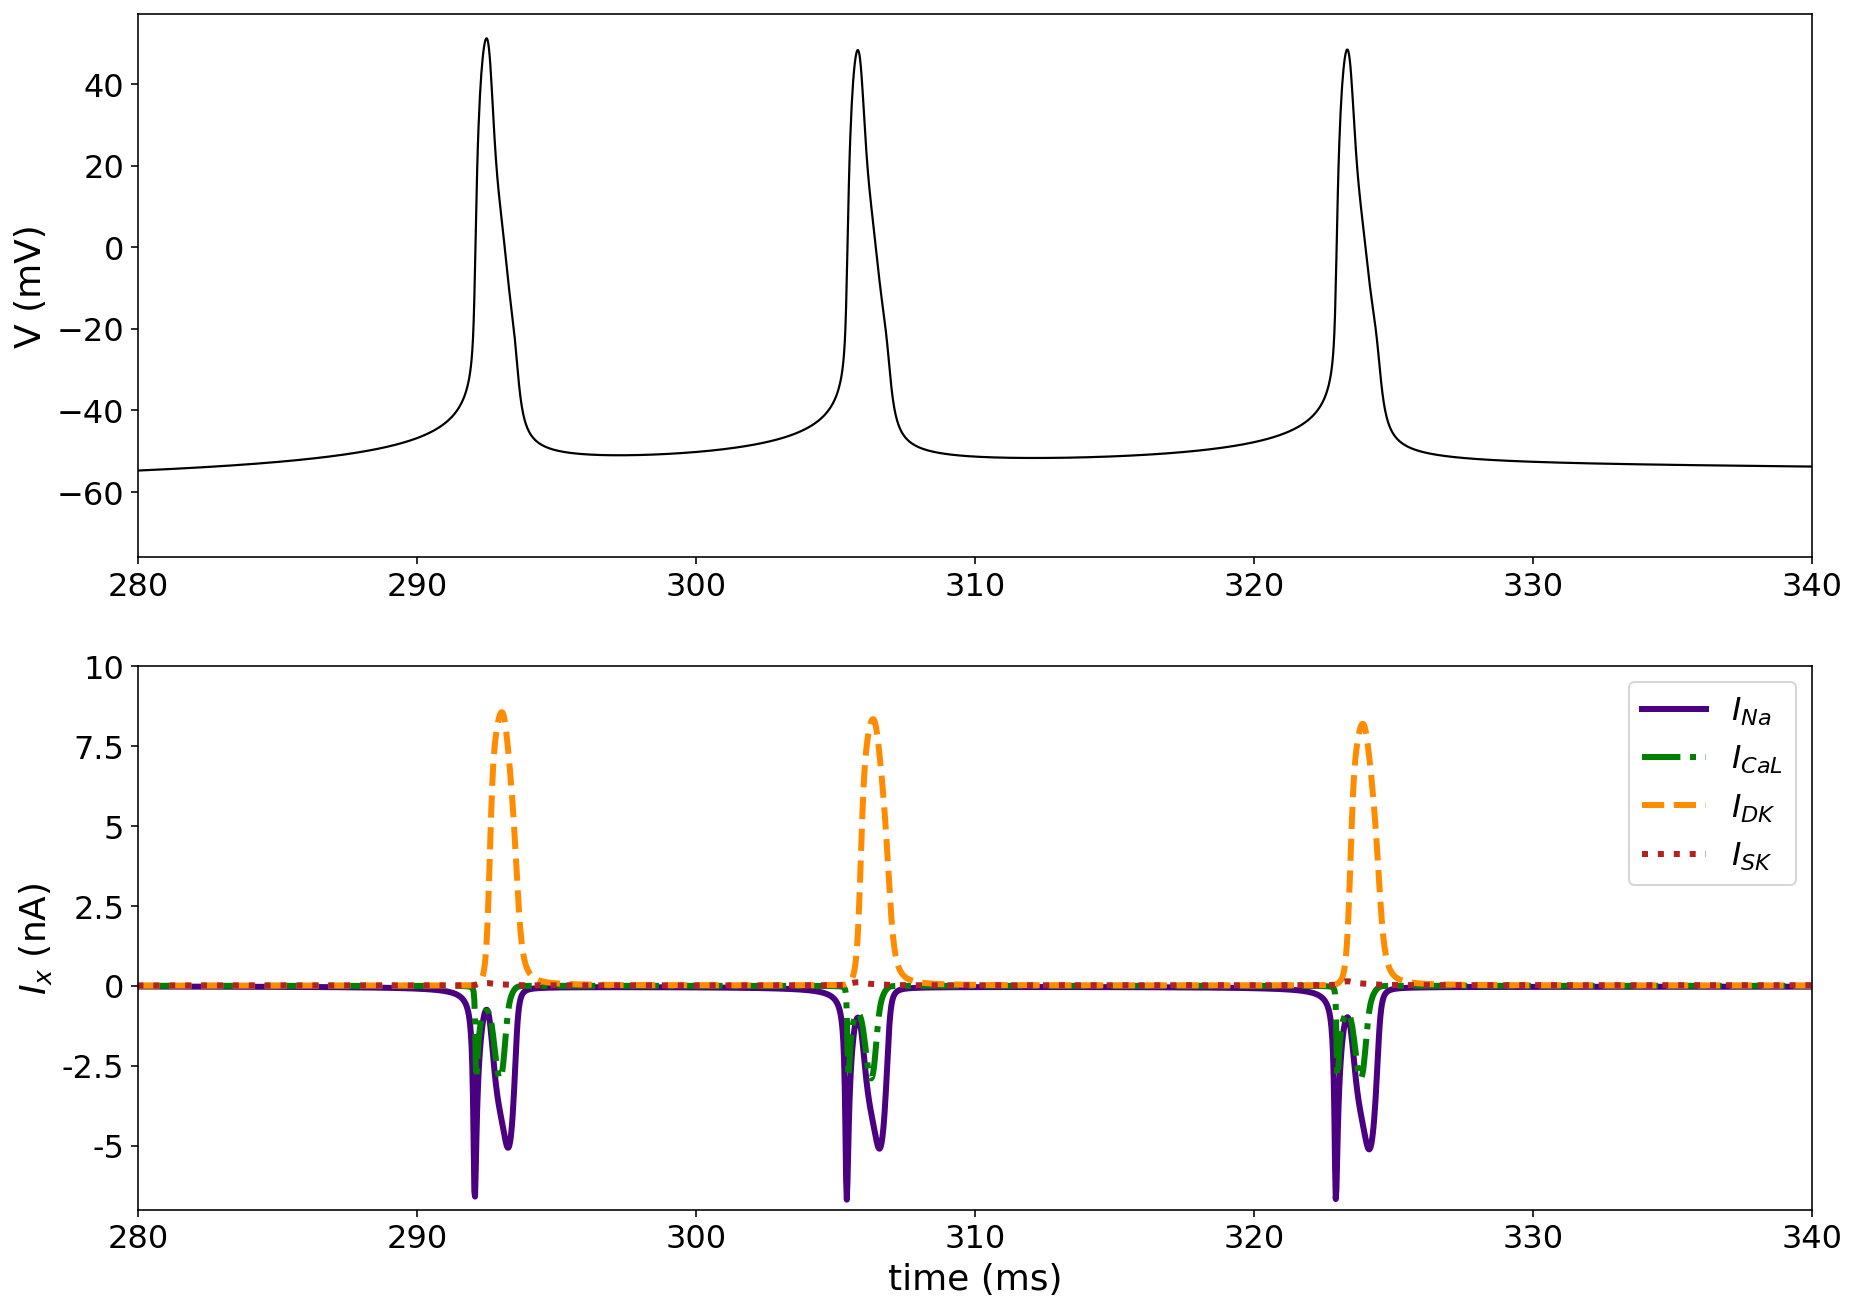

In [114]:
# plot just a few spikes from above simulation and currents
ax1=list()
fig1=pl.figure(figsize=(15,11))
pl.ioff()
rows=2; cols=1
for s in nu.arange(rows*cols):
    ax1.append(fig1.add_subplot(rows,cols,s+1))

ax1[0].plot(nrn.timeSamples, v,'k')
ax1[0].set_ylabel('V (mV)')
ax1[0].set_xlim(280,340)

ticks_y=ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1000))
ax1[1].yaxis.set_major_formatter(ticks_y)
ax1[1].plot(nrn.timeSamples, nrn.jNaT, linestyle='solid', linewidth=3.0, color='indigo', label=r'$I_{Na}$')
ax1[1].plot(nrn.timeSamples, nrn.jCaL, linestyle='dashdot', linewidth=3.0, color='green', label=r'$I_{CaL}$')
ax1[1].plot(nrn.timeSamples, nrn.jDK, linestyle='dashed', linewidth=3.0, color='darkorange', label=r'$I_{DK}$')
ax1[1].plot(nrn.timeSamples, nrn.jSK, linestyle='dotted', linewidth=3.0, color='firebrick', label=r'$I_{SK}$')
#ax1[1].plot(nrn.timeSamples, nrn.jNaK, label=r'$I_{NaK}$')
ax1[1].set_xlabel('time (ms)')
ax1[1].set_ylabel('$I_{x}$ (nA)')
ax1[1].set_xlim( 280,340)
ax1[1].set_ylim(-7000,10000)
ax1[1].legend(loc="upper right");

In [115]:
# young PC
nrn_y = pyrCA1(pars)
nrn_y.a_NaT = 2300; 
nrn_y.a_NaK = nrn_y.a_NaT/100; 
nrn_y.a_DK = 7000; 
nrn_y.a_CaL = 25; 
nrn_y.a_SK = 300; 
nrn_y.r_in_Ca = 5e-3; 
nrn_y.r_Act_DK = 1.1; 
nrn_y.r_conv_Ca = 6e-6; 

nrn_y.reparametrize()
nrn_y.v0 = -70.0; nrn_y.w0 = 0.001; nrn_y.c0=1e-4;
nrn_y.timeMax = 3500.0;  
nrn_y.startIClamp = 200; nrn_y.stopIClamp = 300; nrn_y.iClampAmp=0*10.0; iClamp = nrn_y.IClamp()
v,w,c = nrn_y.RK2_Autonomous(parNames=['A_F',],parValues=[iClamp,])
nrn_y.calcBiophysicsFromDynamics(v,w,c)

# aged (old) PC
nrn_o = pyrCA1(pars)
nrn_o.a_NaT = 2300; 
nrn_o.a_NaK = nrn_o.a_NaT/100; 
nrn_o.a_DK = 7000; 
nrn_o.a_CaL = 50; 
nrn_o.a_SK = 300; 
nrn_o.r_in_Ca = 5e-3;
nrn_o.r_Act_DK = 1.1; 
nrn_o.r_conv_Ca = 6e-6; 

nrn_o.reparametrize()
nrn_o.v0 = -70.0; nrn_o.w0 = 0.001; nrn_o.c0=1e-4;
nrn_o.timeMax = 3500.0;  
nrn_o.startIClamp = 200; nrn_o.stopIClamp = 1000; nrn_o.iClampAmp=0*10.0; iClamp = nrn_o.IClamp()
v,w,c = nrn_o.RK2_Autonomous(parNames=['A_F',],parValues=[iClamp,])
nrn_o.calcBiophysicsFromDynamics(v,w,c);

A_NaK = 0.0299325, A_DK = 23.946, A_SK = 4.19055, A_NaT = 2.99325, A_CaL = 0.149663,         all in V/s
a_NaK = 10, a_DK = 8000, a_SK = 1400, a_NaT = 1000, a_CaL = 25,         all in pA
A_NaK = 0.0688448, A_DK = 20.9528, A_SK = 0.897975, A_NaT = 6.88448, A_CaL = 0.149663,         all in V/s
a_NaK = 23, a_DK = 7000, a_SK = 300, a_NaT = 2300, a_CaL = 25,         all in pA
[ 8000  8001  8002 ... 11997 11998 11999] [0. 0. 0. ... 0. 0. 0.]
Calculating numerical solution
['A_F'] [array([0., 0., 0., ..., 0., 0., 0.])] 1 forcing parameters
nSteps = 140000
A_NaK = 0.0299325, A_DK = 23.946, A_SK = 4.19055, A_NaT = 2.99325, A_CaL = 0.149663,         all in V/s
a_NaK = 10, a_DK = 8000, a_SK = 1400, a_NaT = 1000, a_CaL = 25,         all in pA
A_NaK = 0.0688448, A_DK = 20.9528, A_SK = 0.897975, A_NaT = 6.88448, A_CaL = 0.299325,         all in V/s
a_NaK = 23, a_DK = 7000, a_SK = 300, a_NaT = 2300, a_CaL = 50,         all in pA
[ 8000  8001  8002 ... 39997 39998 39999] [0. 0. 0. ... 0. 0. 0.]
Calcula

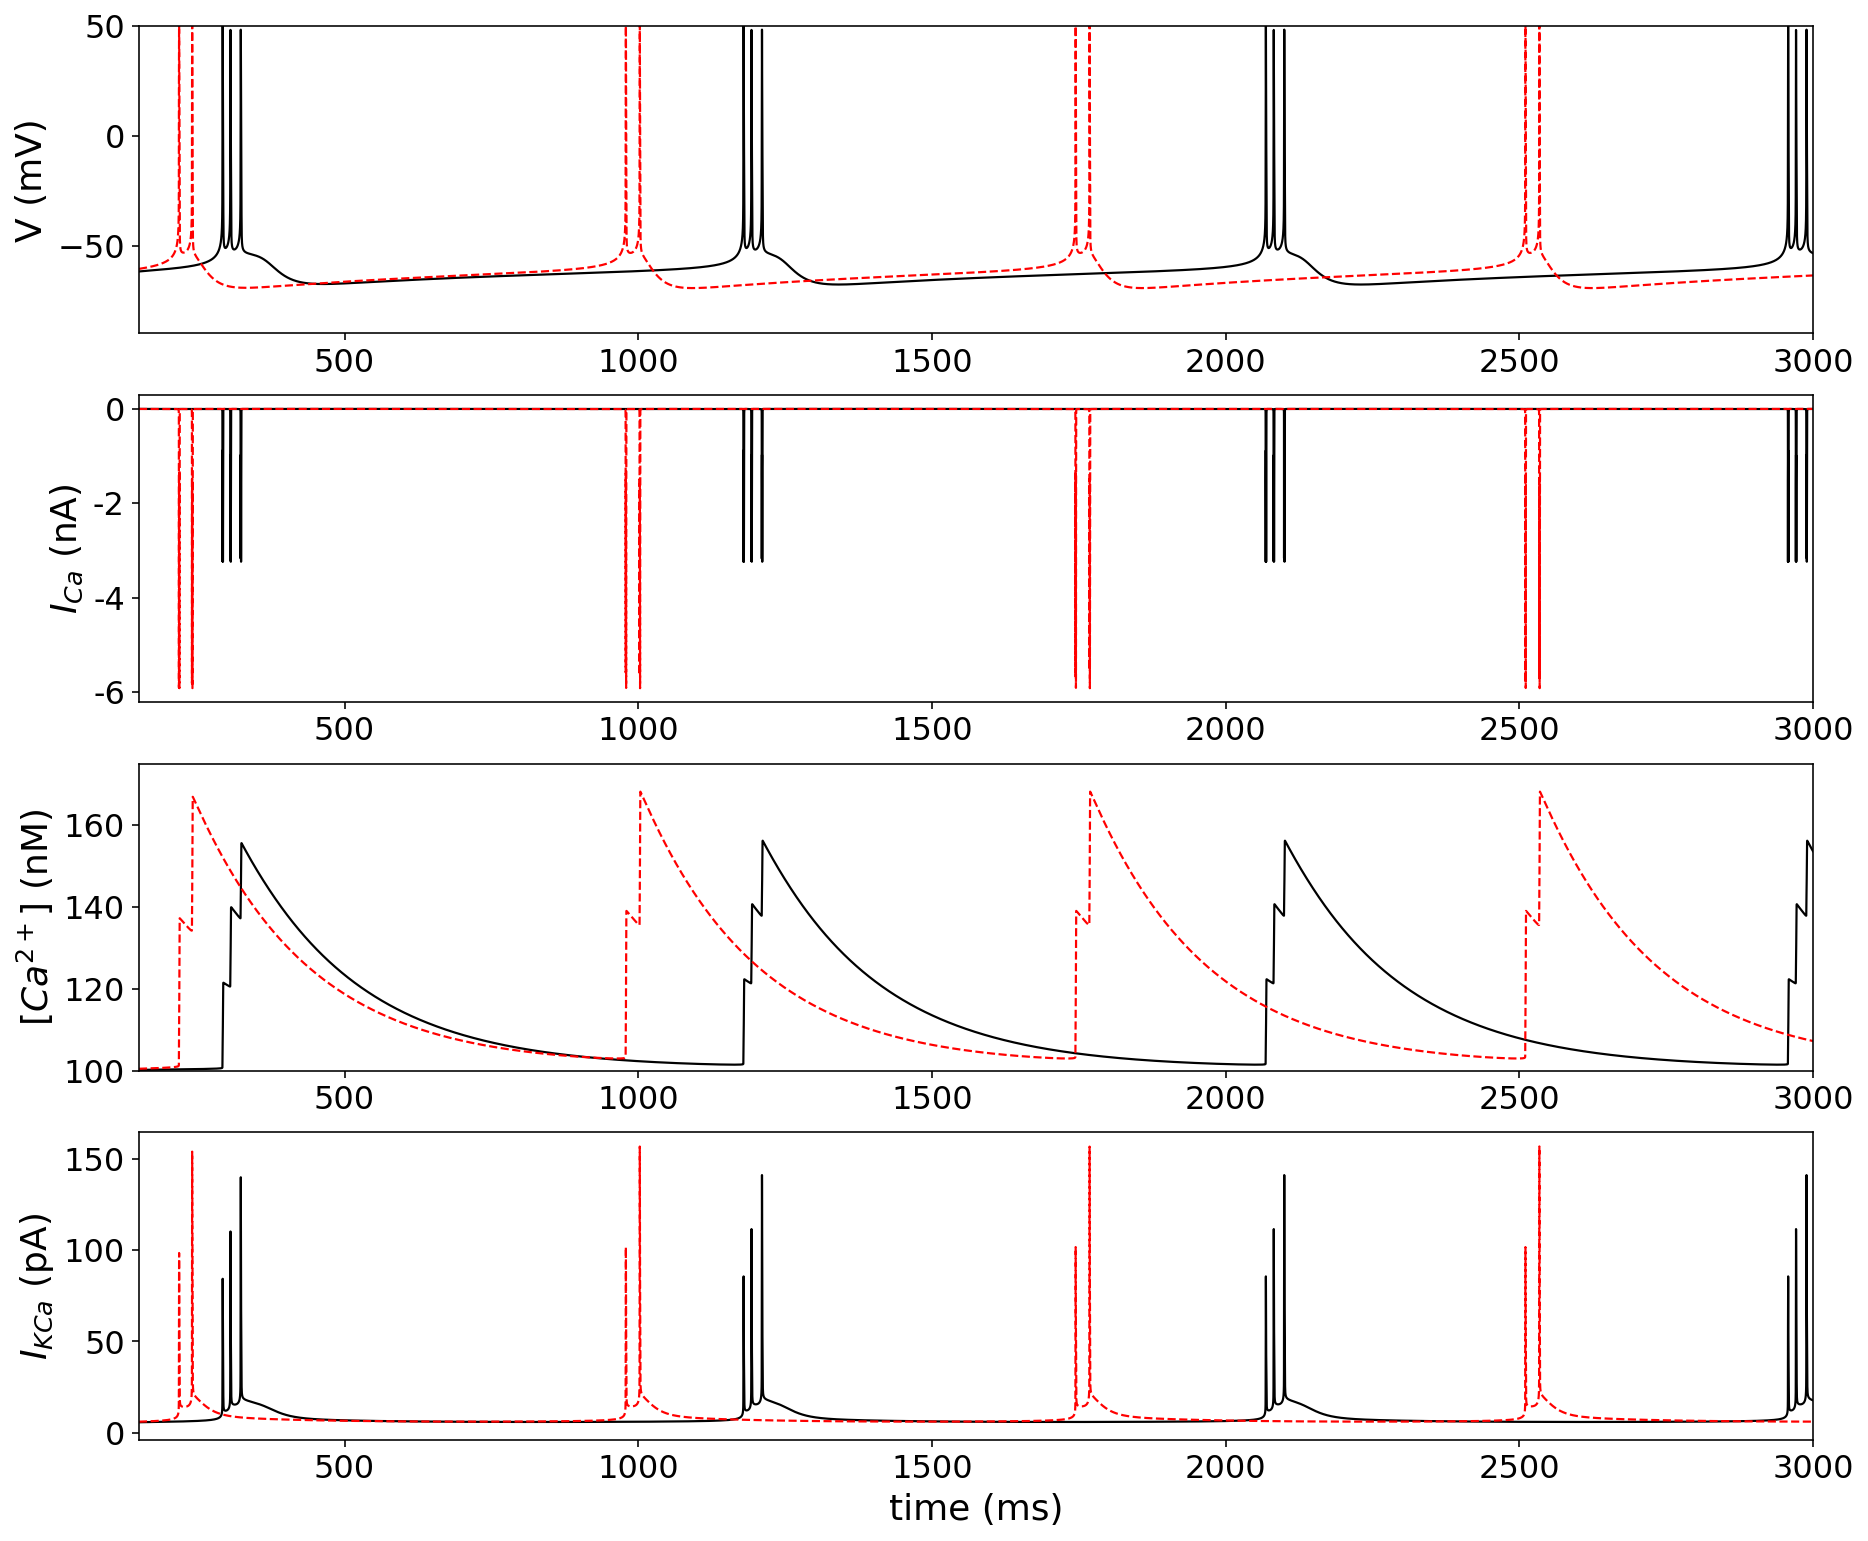

In [116]:
# plot and compare bursting in young and aged PCs
ax1=list()
fig1=pl.figure(figsize=(15,13))
pl.ioff()
rows=4; cols=1
for s in nu.arange(rows*cols):
    ax1.append(fig1.add_subplot(rows,cols,s+1))
    
ax1[0].plot(nrn_y.timeSamples,nrn_y.v,linestyle='solid',color='k')
ax1[0].plot(nrn_o.timeSamples,nrn_o.v,linestyle='dashed',color='r')
ax1[0].set_ylabel('V (mV)')
ax1[0].set_ylim(-90,50)
ax1[0].set_xlim(150,3000)
        
ticks_y=ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1000))
ax1[1].yaxis.set_major_formatter(ticks_y)
ax1[1].plot(nrn_y.timeSamples,nrn_y.jCaL,linestyle='solid',color='k')
ax1[1].plot(nrn_o.timeSamples,nrn_o.jCaL,linestyle='dashed',color='r')
ax1[1].set_ylabel('$I_{Ca}$ (nA)')
ax1[1].set_xlim(150,3000)

scale_y2=1e-6
ticks_y=ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y2))
ax1[2].yaxis.set_major_formatter(ticks_y)
ax1[2].plot(nrn_y.timeSamples,nrn_y.c,linestyle='solid',color='k')
ax1[2].plot(nrn_o.timeSamples,nrn_o.c,linestyle='dashed',color='r')
ax1[2].set_xlim(150,3000)
ax1[2].set_ylim(1e-4,1.75e-4)
ax1[2].set_ylabel('[$Ca^{2+}$] (nM)')

ax1[3].plot(nrn_y.timeSamples,nrn_y.jSK,linestyle='solid',color='k')
ax1[3].plot(nrn_o.timeSamples,nrn_o.jSK,linestyle='dashed',color='r')
ax1[3].set_xlabel('time (ms)')
ax1[3].set_ylabel('$I_{KCa}$ (pA)')
ax1[3].set_xlim(150,3000);
#ax1[3].set_ylim(130,160);

In [117]:
# different DK amplitudes to loop through
aDKs=(8000,7500,7000,6500,6000) 
naDKs=len(aDKs)

simsy = list()
simso = list()

for i in range(naDKs):
    # young PC
    nrn_y.a_DK=aDKs[i]; 
    nrn_y.reparametrize()
    nrn_y.v0 = -70.0; nrn_y.w0 = 0.001; nrn_y.c0=1e-4;
    nrn_y.iClampAmp=0*65.0; iClamp = nrn_y.IClamp()
    v,w,c = nrn_y.RK2_Autonomous(parNames=['A_F',],parValues=[iClamp,]);
    oo=nrn_y.calcBiophysicsFromDynamics(v,w,c);
    simsy.append(oo);
    # aged (old) PC
    nrn_o.a_DK=aDKs[i];
    nrn_o.reparametrize()
    nrn_o.v0 = -70.0; nrn_o.w0 = 0.001; nrn_o.c0=1e-4;
    nrn_o.iClampAmp=0*65.0; iClamp = nrn_o.IClamp()
    v,w,c = nrn_o.RK2_Autonomous(parNames=['A_F',],parValues=[iClamp,]);
    oo=nrn_o.calcBiophysicsFromDynamics(v,w,c);
    simso.append(oo);

A_NaK = 0.0688448, A_DK = 23.946, A_SK = 0.897975, A_NaT = 6.88448, A_CaL = 0.149663,         all in V/s
a_NaK = 23, a_DK = 8000, a_SK = 300, a_NaT = 2300, a_CaL = 25,         all in pA
[ 8000  8001  8002 ... 11997 11998 11999] [0. 0. 0. ... 0. 0. 0.]
Calculating numerical solution
['A_F'] [array([0., 0., 0., ..., 0., 0., 0.])] 1 forcing parameters
nSteps = 140000
A_NaK = 0.0688448, A_DK = 23.946, A_SK = 0.897975, A_NaT = 6.88448, A_CaL = 0.299325,         all in V/s
a_NaK = 23, a_DK = 8000, a_SK = 300, a_NaT = 2300, a_CaL = 50,         all in pA
[ 8000  8001  8002 ... 39997 39998 39999] [0. 0. 0. ... 0. 0. 0.]
Calculating numerical solution
['A_F'] [array([0., 0., 0., ..., 0., 0., 0.])] 1 forcing parameters
nSteps = 140000
A_NaK = 0.0688448, A_DK = 22.4494, A_SK = 0.897975, A_NaT = 6.88448, A_CaL = 0.149663,         all in V/s
a_NaK = 23, a_DK = 7500, a_SK = 300, a_NaT = 2300, a_CaL = 25,         all in pA
[ 8000  8001  8002 ... 11997 11998 11999] [0. 0. 0. ... 0. 0. 0.]
Calculating n

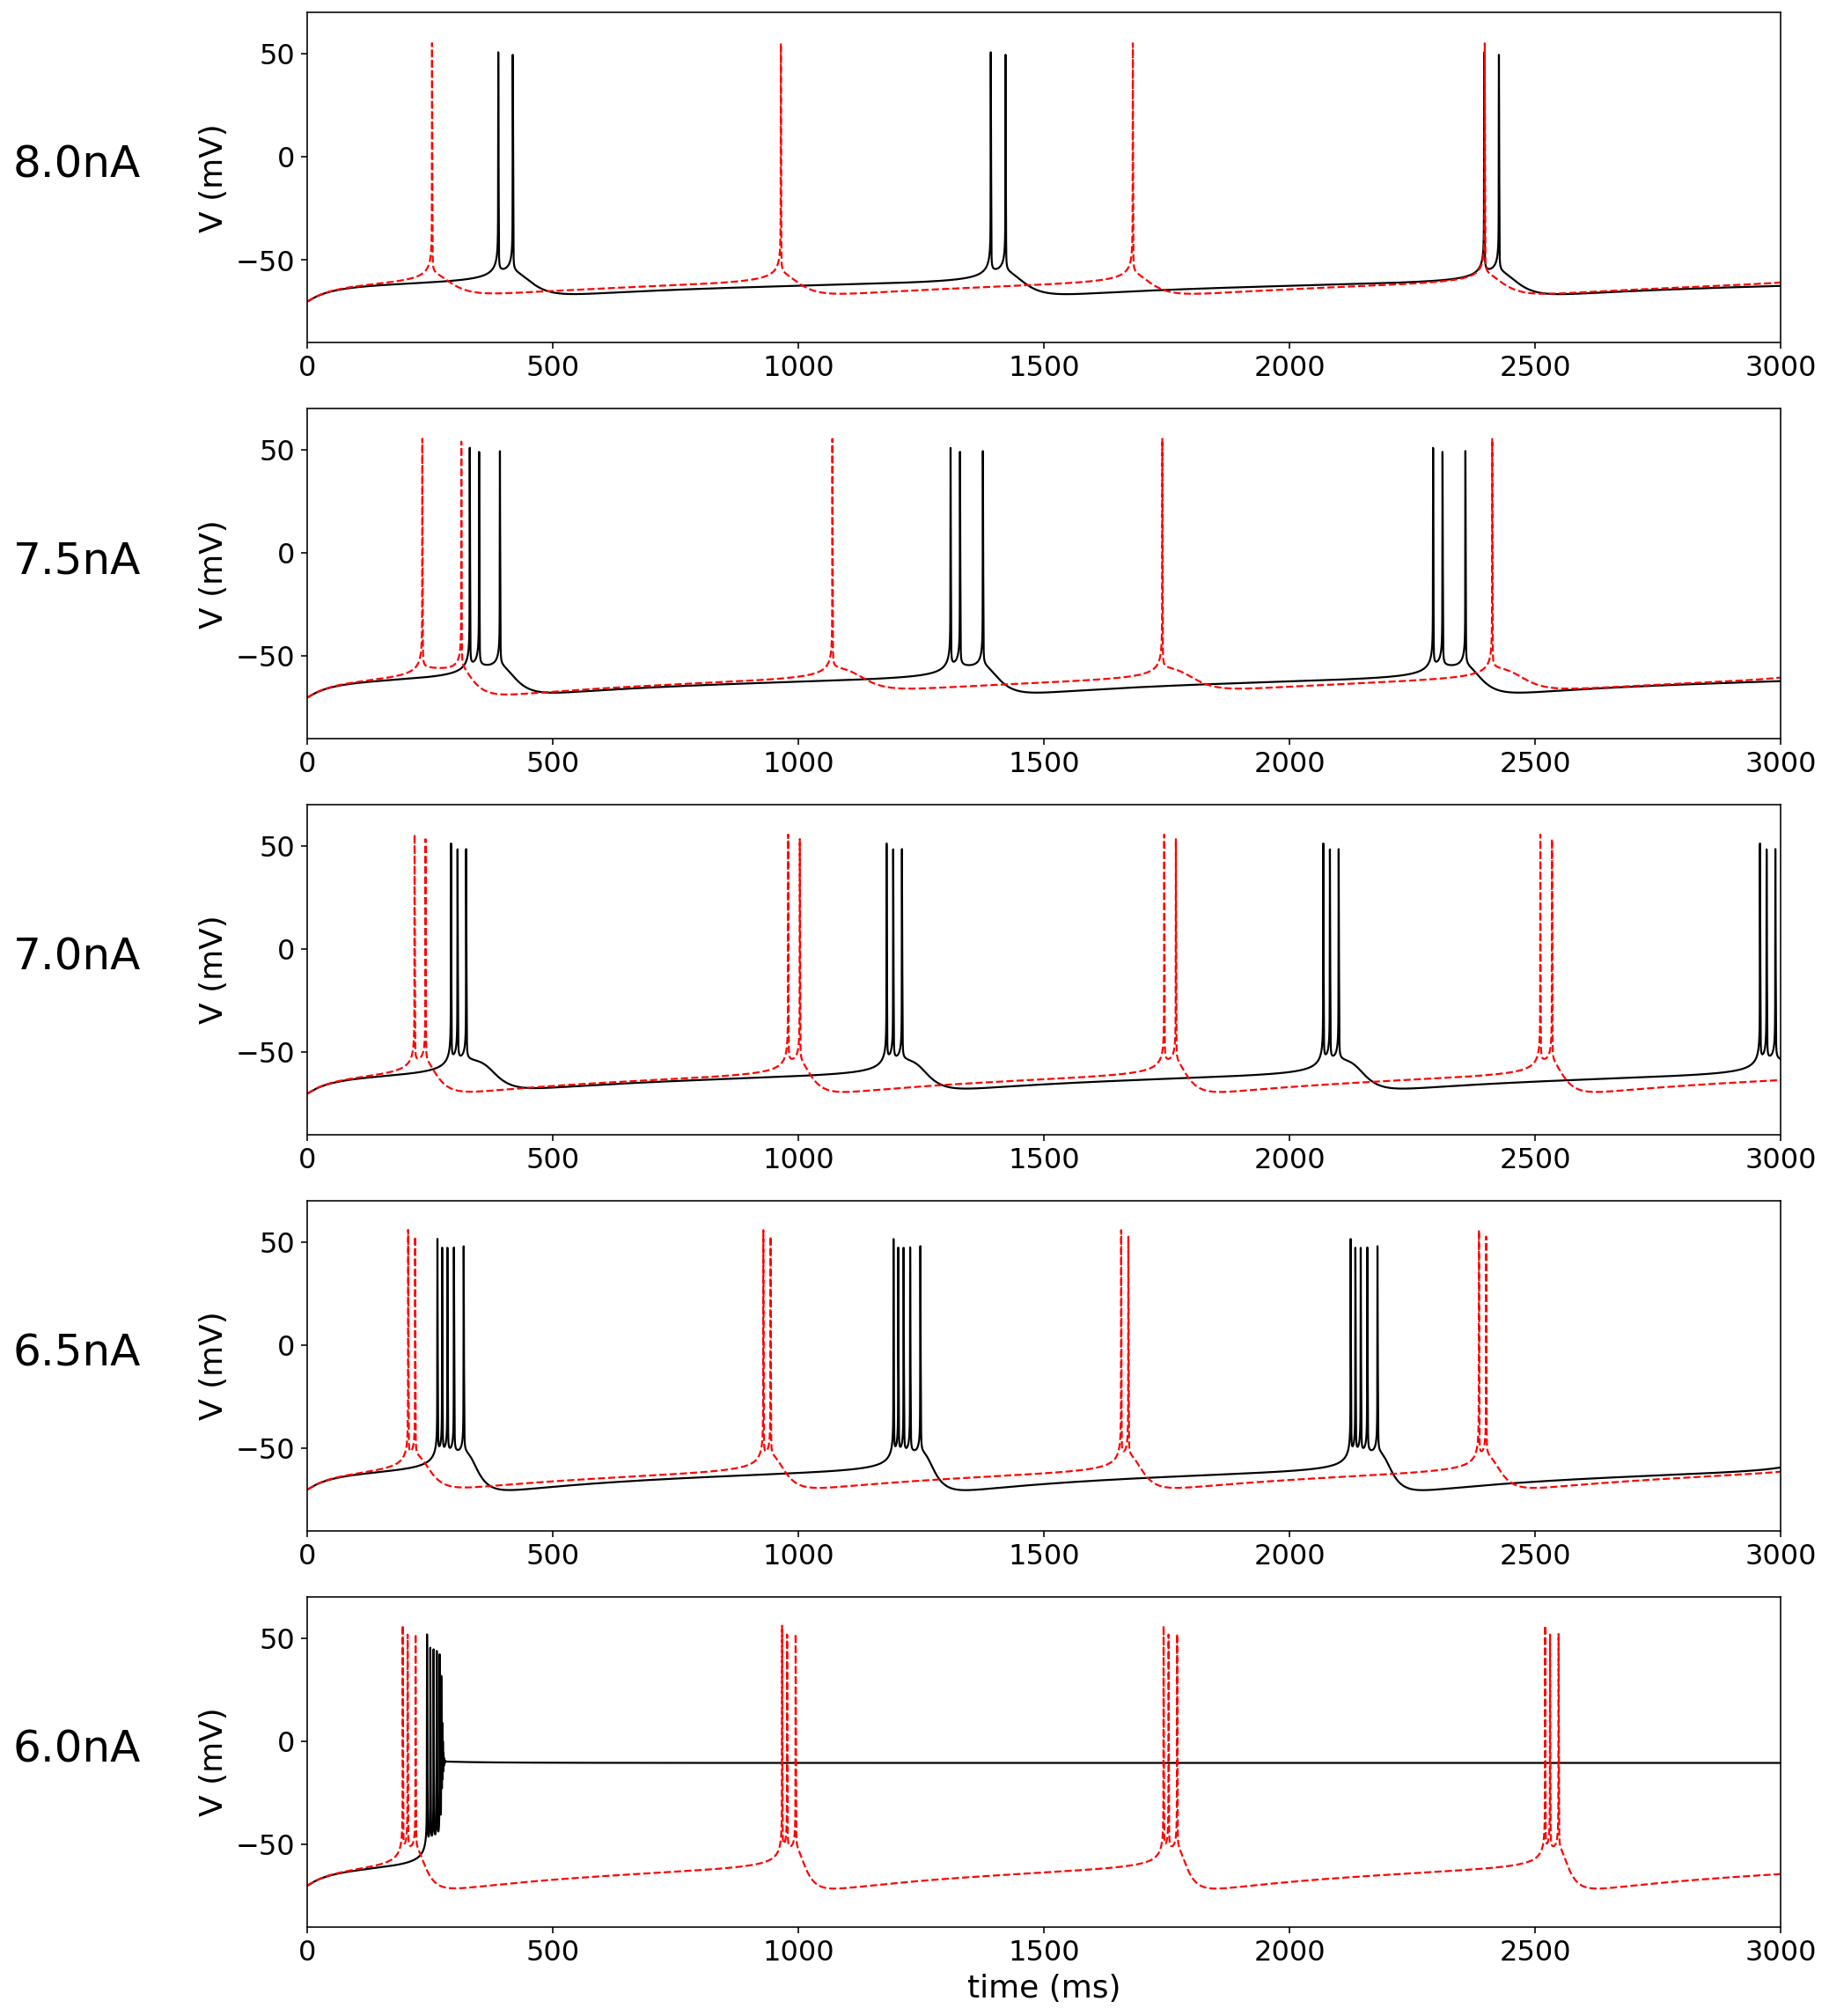

In [118]:
# plot the results of the above simulations 
ax1=list()
fig1=pl.figure(figsize=(15,20))
pl.rcParams['lines.linewidth'] = 1.1
pl.ioff()
rows=naDKs; cols=1
for s in nu.arange(rows*cols):
    ax1.append(fig1.add_subplot(rows,cols,s+1))

for i in range(naDKs):
    # plot young PC activity
    ax1[i].plot(nrn_y.timeSamples,simsy[i][0],linestyle='solid',color='k')
    ax1[i].text(-0.2, 0.5,'%.1f'%(aDKs[i]/1000)+'nA',size=25,transform=ax1[i].transAxes)
    ax1[i].set_ylabel('V (mV)')
    ax1[i].set_ylim(-90,70)
    ax1[i].set_xlim(0,3000)
    # plot aged PC activity
    ax1[i].plot(nrn_o.timeSamples,simso[i][0],linestyle='dashed',color='r')
    ax1[i].set_ylabel('V (mV)')
    ax1[i].set_ylim(-90,70)
    ax1[i].set_xlim(0,3000)
    
pl.xlabel('time (ms)');

## Local field potential forcing
While square pulse stimulation is useful for examining the timing of neural responses, it is not a physiologically realistic stimulus. Instead, we can define an Ornstein-Uhlenbeck stochastic process to simulate local field potential (LFP) forcing that CA1 PCs could experience due to the electrical activity of cells in their vicinity. We set it up so one can easily switch between the different parameter sets that give either adaptive firing or conditional bursting to then see the effects of OU forcing. Note that these figures will not come out identical to those in the main paper, since the stimulation is a stochastic process, but the overall effect will be reproduced. 

In [119]:
# enter 1 to run the following parameter sets for adaptive firing mode
if 1:
    # young PC with OU forcing
    nrn_y = pyrCA1(pars)
    nrn_y.a_NaT = 1000; 
    nrn_y.a_NaK = nrn.a_NaT/100; 
    nrn_y.a_DK = 8000; 
    nrn_y.a_CaL = 25; 
    nrn_y.a_SK = 1400; 
    nrn_y.r_in_Ca = 1e-3;
    nrn_y.r_Act_DK = 1.0;
    nrn_y.r_conv_Ca = 3e-6; 
    nrn_y.aMean=50.0;
    nrn_y.aSD=25.0;
    nrn_y.aTau=1/2.0;
#
    nrn_y.reparametrize()
    nrn_y.timeMax = 4000.0;
    v,w,c = nrn_y.runWOU()

    # aged (old) PC with OU forcing
    nrn_o = pyrCA1(pars)
    nrn_o.a_NaT = 1000; 
    nrn_o.a_NaK = nrn.a_NaT/100; 
    nrn_o.a_DK = 8000; 
    nrn_o.a_CaL = 50; 
    nrn_o.a_SK = 1400; 
    nrn_o.r_in_Ca = 1e-3;
    nrn_o.r_Act_DK = 1.0;
    nrn_o.r_conv_Ca = 3e-6; 
    nrn_o.aMean=50.0;
    nrn_o.aSD=25.0;
    nrn_o.aTau=1/2.0;
    #
    nrn_o.reparametrize()
    nrn_o.timeMax = 4000.0;
    v,w,c = nrn_o.runWOU();

# enter 1 to run the following parameters for conditional bursting mode
if 0: 
    # young PC with OU forcing
    nrn_y = pyrCA1(pars)
    nrn_y.a_NaT = 1300; 
    nrn_y.a_NaK = nrn.a_NaT/100; 
    nrn_y.a_DK = 6000; 
    nrn_y.a_CaL = 25; 
    nrn_y.a_SK = 1600; 
    nrn_y.r_in_Ca = 5e-3;
    nrn_y.r_Act_DK = 1.8;
    nrn_y.r_conv_Ca = 6e-6; 
    nrn_y.aMean=50.0;
    nrn_y.aSD=20.0;
    nrn_y.aTau=1/2.0;
    #
    nrn_y.reparametrize()
    nrn_y.timeMax = 2000.0;
    v,w,c = nrn_y.runWOU()

    # aged (old) PC with OU forcing
    nrn_o = pyrCA1(pars)
    nrn_o.a_NaT = 1300; 
    nrn_o.a_NaK = nrn.a_NaT/100; 
    nrn_o.a_DK = 6000; 
    nrn_o.a_CaL = 50; 
    nrn_o.a_SK = 1600; 
    nrn_o.r_in_Ca = 5e-3;
    nrn_o.r_Act_DK = 1.8;
    nrn_o.r_conv_Ca = 6e-6; 
    nrn_o.aMean=50.0;
    nrn_o.aSD=20.0;
    nrn_o.aTau=1/2.0;
    #
    nrn_o.reparametrize()
    nrn_o.timeMax = 2000.0;
    v,w,c = nrn_o.runWOU();

A_NaK = 0.0299325, A_DK = 23.946, A_SK = 4.19055, A_NaT = 2.99325, A_CaL = 0.149663,         all in V/s
a_NaK = 10, a_DK = 8000, a_SK = 1400, a_NaT = 1000, a_CaL = 25,         all in pA
A_NaK = 0.0688448, A_DK = 23.946, A_SK = 4.19055, A_NaT = 2.99325, A_CaL = 0.149663,         all in V/s
a_NaK = 23, a_DK = 8000, a_SK = 1400, a_NaT = 1000, a_CaL = 25,         all in pA
[ 0.         -0.01296381  0.02455422 ...  0.04708384  0.05330048
  0.072375  ]
Calculating numerical solution
['A_F'] [array([ 0.        , -0.01296381,  0.02455422, ...,  0.04708384,
        0.05330048,  0.072375  ])] 1 forcing parameters
nSteps = 160000
A_NaK = 0.0299325, A_DK = 23.946, A_SK = 4.19055, A_NaT = 2.99325, A_CaL = 0.149663,         all in V/s
a_NaK = 10, a_DK = 8000, a_SK = 1400, a_NaT = 1000, a_CaL = 25,         all in pA
A_NaK = 0.0688448, A_DK = 23.946, A_SK = 4.19055, A_NaT = 2.99325, A_CaL = 0.299325,         all in V/s
a_NaK = 23, a_DK = 8000, a_SK = 1400, a_NaT = 1000, a_CaL = 50,         all in pA
[

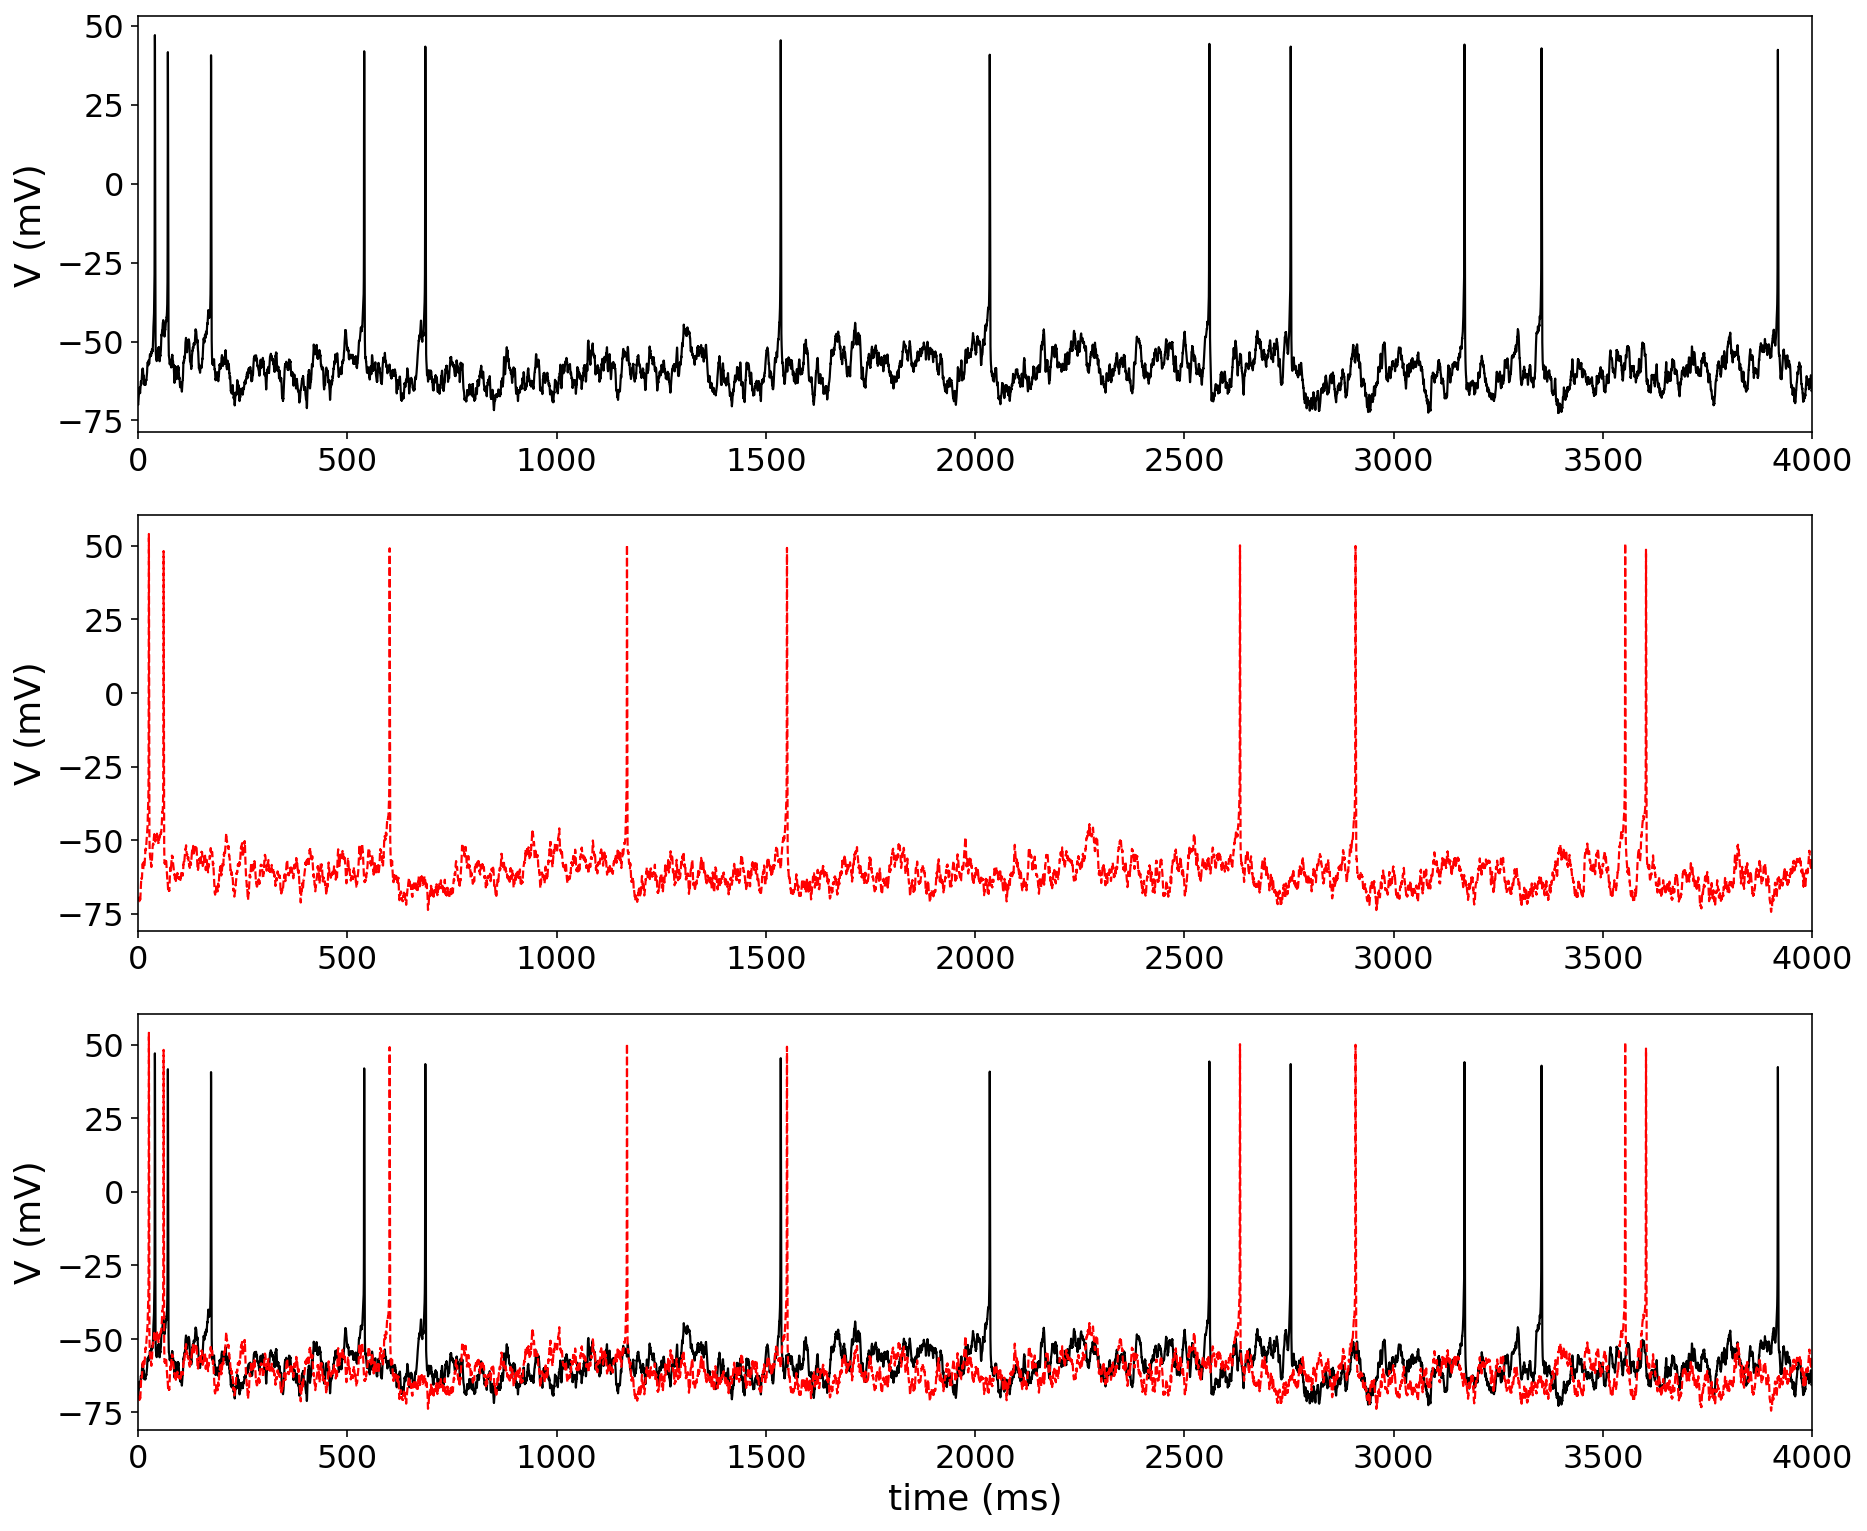

In [120]:
ax1=list()
fig1=pl.figure(figsize=(15,13))
pl.ioff()
rows=3; cols=1
for s in nu.arange(rows*cols):
    ax1.append(fig1.add_subplot(rows,cols,s+1))
    
ax1[0].plot(nrn_y.timeSamples,nrn_y.v,linestyle='solid',color='k')
ax1[0].set_ylabel('V (mV)')
ax1[0].set_xlim(0,4000)

ax1[1].plot(nrn_o.timeSamples,nrn_o.v,linestyle='dashed',color='r')
ax1[1].set_ylabel('V (mV)')
ax1[1].set_xlim(0,4000)

ax1[2].plot(nrn_y.timeSamples,nrn_y.v,linestyle='solid',color='k')
ax1[2].plot(nrn_y.timeSamples,nrn_o.v,linestyle='dashed',color='r')
ax1[2].set_xlabel('time (ms)')
ax1[2].set_ylabel('V (mV)')
ax1[2].set_xlim(0,4000);